In [63]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sb

sb.set_style('white')

In [64]:
num_simulations = 100_000

In [65]:
resources = ['rocks', 'shards', 'stones', 'fusion', 'silver', 'gold']

# Overview

Starting with T3. Data from maxroll.gg and easymari.com

Based on my research the success rate for an item increases by 0.1 * base_rate (up to a hard cap) and artisan rate increases by 0.465 * current_rate. Upgrade chance becomes 100% once artisan rate reaches 100%. Some spot checking in the game corroborates this.

What I don't know for sure:
- How success rate hard caps work
  - Appears to be 2 * base_rate but I can't find hard proof of this
  - What happens with juicing when success rate caps out?
- How stronghold buffs factor in
  - Tooltip descriptions are somewhat unclear
  - Will check this once I hit 1385 and research it
  
Whats missing for sure:
- The one-time shard cost for upgrading each piece (can't find this anywhere, have been collecting as i go
- Juicing (for now)


Given a base probabilities table, this function rolls out the success and artisan rates for each attempt.

In [66]:
def rates_table(p_table: pd.DataFrame, artisan_multiplier=0.465):
    rates = []
    for _, row in p_table.iterrows():
        attempt = 0
        artisan_rate = 0.00
        success_rate = row.base_rate
        increase_rate = row.base_rate * 0.1
        while True:
            attempt += 1
            if artisan_rate >= 1 or success_rate >= 1:
                break
            rates.append((row.level, attempt, artisan_rate, success_rate))
            artisan_rate = np.round(artisan_rate + artisan_multiplier * success_rate, 4)
            success_rate = np.round(np.min([success_rate + increase_rate, 2 * row.base_rate]), 4)
        rates.append((row.level, attempt, 1.0, 1.0))

    return pd.DataFrame(rates, columns=('level', 'attempt', 'artisan_rate', 'success_rate'))

# Tier 3a (1100-1370)

In [67]:
probs = pd.DataFrame(
    columns=('level', 'ilvl', 'base_rate'),
    data=[
        ( 1, 1304, 1.00),
        ( 2, 1307, 1.00),
        ( 3, 1310, 1.00),
        ( 4, 1315, 1.00),
        ( 5, 1320, 1.00),
        ( 6, 1325, 1.00),
        ( 7, 1330, 0.60),
        ( 8, 1335, 0.45),
        ( 9, 1340, 0.30),
        (10, 1345, 0.30),
        (11, 1350, 0.30),
        (12, 1355, 0.15),
        (13, 1360, 0.15),
        (14, 1365, 0.15),
        (15, 1370, 0.10),
    ]
)
probs.level = probs.level.astype('int')
probs

,level,ilvl,base_rate
0,1,1304,1.00
1,2,1307,1.00
2,3,1310,1.00
3,4,1315,1.00
4,5,1320,1.00
5,6,1325,1.00
6,7,1330,0.60
7,8,1335,0.45
8,9,1340,0.30
9,10,1345,0.30


In [68]:
gear_costs = pd.DataFrame(
    columns=('level', *resources),
    dtype=int,
    data=[
        ( 1,  82, 22, 2, 0, 11100,  0),
        ( 2,  82, 22, 2, 0, 11380,  0),
        ( 3,  82, 22, 2, 0, 11660,  0),
        ( 4, 120, 32, 4, 2, 11960,  0),
        ( 5, 120, 32, 4, 2, 12240,  0),
        ( 6, 120, 32, 4, 2, 12540,  0),
        ( 7, 156, 42, 4, 2, 12840, 70),
        ( 8, 156, 42, 4, 2, 13160, 70),
        ( 9, 156, 42, 4, 2, 13480, 70),
        (10, 192, 50, 6, 4, 13820, 70),
        (11, 192, 50, 6, 4, 14140, 70),
        (12, 192, 50, 6, 4, 14500, 70),
        (13, 228, 60, 6, 4, 14860, 70),  # this 6 stones seems wrong, should be 8?
        (14, 228, 60, 8, 4, 15220, 70),
        (15, 228, 60, 8, 4, 15600, 70),
    ]
)

gear_costs

,level,rocks,shards,stones,fusion,silver,gold
0,1,82,22,2,0,11100,0
1,2,82,22,2,0,11380,0
2,3,82,22,2,0,11660,0
3,4,120,32,4,2,11960,0
4,5,120,32,4,2,12240,0
5,6,120,32,4,2,12540,0
6,7,156,42,4,2,12840,70
7,8,156,42,4,2,13160,70
8,9,156,42,4,2,13480,70
9,10,192,50,6,4,13820,70


In [69]:
weapon_costs = pd.DataFrame(
    columns=('level', *resources),
    dtype=int,
    data=[
        ( 1, 138, 32,  4, 0, 15860,   0),
        ( 2, 138, 32,  4, 0, 16240,   0),
        ( 3, 198, 32,  6, 0, 16550,   0),  # rocks increase at lvl 4 for gear, weapon at 3, is this correct?
        ( 4, 198, 46,  6, 2, 17040,   0),
        ( 5, 198, 46,  6, 2, 17460,   0),
        ( 6, 198, 46,  6, 2, 17900,   0),
        ( 7, 258, 60,  8, 4, 18320, 120),
        ( 8, 258, 60,  8, 4, 18780, 120),
        ( 9, 258, 60,  8, 4, 19240, 120),
        (10, 320, 74, 10, 4, 19720, 120),
        (11, 320, 74, 10, 4, 20200, 120),
        (12, 320, 74, 10, 4, 20700, 120),
        (13, 380, 88, 10, 6, 21200, 120),
        (14, 380, 88, 12, 6, 21720, 120),
        (15, 380, 88, 12, 6, 22260, 120),
    ]
)
weapon_costs

,level,rocks,shards,stones,fusion,silver,gold
0,1,138,32,4,0,15860,0
1,2,138,32,4,0,16240,0
2,3,198,32,6,0,16550,0
3,4,198,46,6,2,17040,0
4,5,198,46,6,2,17460,0
5,6,198,46,6,2,17900,0
6,7,258,60,8,4,18320,120
7,8,258,60,8,4,18780,120
8,9,258,60,8,4,19240,120
9,10,320,74,10,4,19720,120


In [70]:
rates = rates_table(probs)
rates.level = rates.level.astype('int')
rates

,level,attempt,artisan_rate,success_rate
0,1,1,1.000,1.0
1,2,1,1.000,1.0
2,3,1,1.000,1.0
3,4,1,1.000,1.0
4,5,1,1.000,1.0
...,...,...,...,...
81,15,11,0.674,0.2
82,15,12,0.767,0.2
83,15,13,0.860,0.2
84,15,14,0.953,0.2


Since each roll is independent, can easily simulate using pandas by repeating the probs table, adding a random uniform column, and selecting the first success from each trial/level grouping.

In [71]:
simulations = (
    pd.concat([
        rates.assign(trial=i+1)
        for i in range(num_simulations)
    ])
    .assign(roll=np.random.uniform(size=rates.shape[0]*num_simulations))
    .query('roll < success_rate')
    .drop(['roll', 'success_rate'], axis=1)
    .groupby(['trial', 'level'], as_index=False)
    .first()
)

This provides a number of simulations of honing level 1-15 and how many attempts until success for each level.

In [72]:
simulations.pivot(index='trial', columns='level', values='attempt')

level,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
trial,,,,,,,,,,,,,,,
1,1,1,1,1,1,1,1,1,1,3,4,4,8,1,10
2,1,1,1,1,1,1,1,3,3,1,6,1,10,4,9
3,1,1,1,1,1,1,1,3,3,4,3,11,10,3,5
4,1,1,1,1,1,1,1,1,3,3,1,5,6,1,11
5,1,1,1,1,1,1,1,2,2,2,5,1,6,3,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99996,1,1,1,1,1,1,1,1,1,1,2,3,5,11,11
99997,1,1,1,1,1,1,2,1,1,1,4,2,11,6,7
99998,1,1,1,1,1,1,1,1,3,3,1,3,11,11,5


A look at distributions of attempts by level

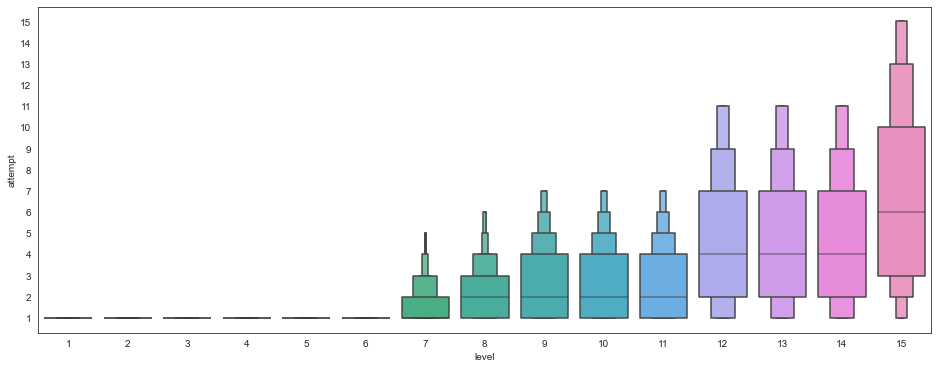

In [73]:
fig, ax = plt.subplots(figsize=(16,6))
sb.boxenplot(data=simulations, x='level', y='attempt', ax=ax);
ax.set_yticks(range(1, simulations.attempt.max()+1));

Breaking down each level individually

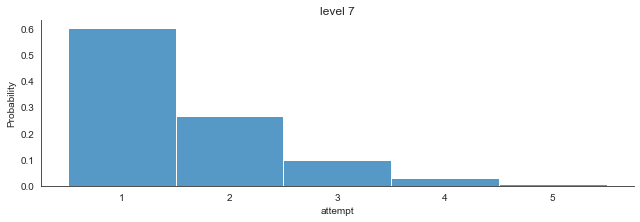

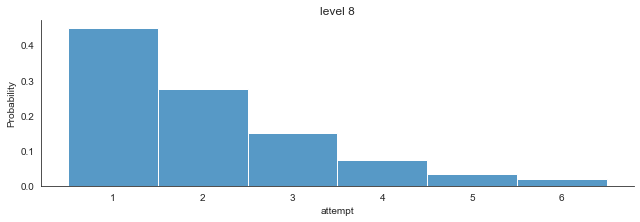

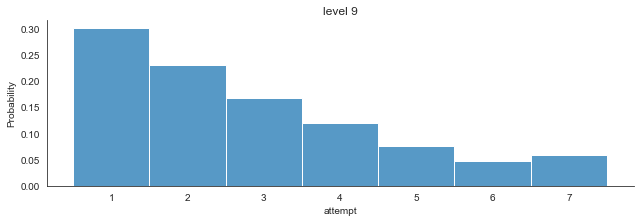

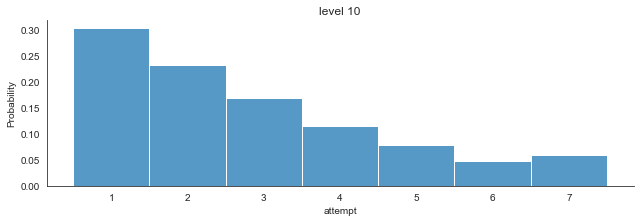

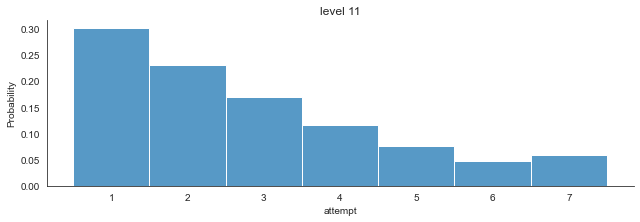

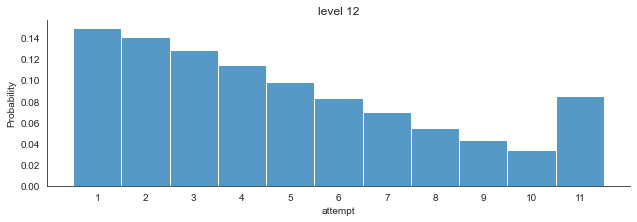

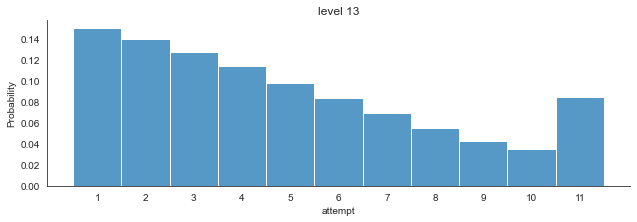

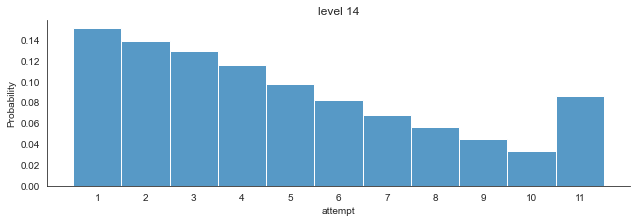

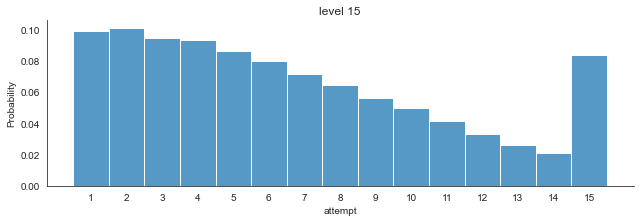

In [74]:
for level, gdf in simulations.query('level >= 7').groupby('level'):
    sb.displot(gdf, x='attempt', discrete=True, stat='probability', aspect=3, height=3)
    plt.tight_layout()
    plt.title(f'level {level}')
    plt.xticks(range(1, gdf.attempt.max() + 1))

A look at the cumulative success probabilities by level/attempt

In [75]:
(
    (
        simulations[['level', 'attempt']]
        .groupby('level')
        .value_counts()
        .div(num_simulations)
    )
    .reset_index()
    .rename({0: 'p'}, axis=1)
    .pivot(index='level', columns='attempt')
    .apply(np.cumsum, axis=1)
    .applymap(lambda p: np.round(p, 2))
    .fillna('--')
)

p                                                              \
attempt    1     2     3     4     5     6     7     8     9     10    11   
level                                                                       
1        1.00    --    --    --    --    --    --    --    --    --    --   
2        1.00    --    --    --    --    --    --    --    --    --    --   
3        1.00    --    --    --    --    --    --    --    --    --    --   
4        1.00    --    --    --    --    --    --    --    --    --    --   
5        1.00    --    --    --    --    --    --    --    --    --    --   
6        1.00    --    --    --    --    --    --    --    --    --    --   
7        0.60  0.86  0.96  0.99   1.0    --    --    --    --    --    --   
8        0.45  0.72  0.87  0.95  0.98   1.0    --    --    --    --    --   
9        0.30  0.53   0.7  0.82  0.89  0.94   1.0    --    --    --    --   
10       0.30  0.53   0.7  0.82  0.89  0.94   1.0    --    --    --    --   
11       0.30  0.53   0.7  0.82  0.89  0.94   1.0    --    --    --    --   
12       0.15  0.29  0.42  0.53  0.63  0.71  0.78  0.84  0.88  0.92   1.0   
13       0.15  0.29  0.42  0.53  0.63  0.71  0.78  0.84  0.88  0.92   1.0   
14       0.15  0.29  0.42  0.53  0.63  0.71  0.78  0.84  0.88  0.91   1.0   
15       0.10   0.2  0.29  0.39  0.47  0.55  0.62  0.69  0.75  0.79  0.84   

                               
attempt    12   13    14   15  
level                          
1          --   --    --   --  
2          --   --    --   --  
3          --   --    --   --  
4          --   --    --   --  
5          --   --    --   --  
6          --   --    --   --  
7          --   --    --   --  
8          --   --    --   --  
9          --   --    --   --  
10         --   --    --   --  
11         --   --    --   --  
12         --   --    --   --  
13         --   --    --   --  
14         --   --    --   --  
15       0.87  0.9  0.92  1.0

Inverting gives the failure rates by level (i.e. what percentage of players will fail attempt X)

In [76]:
(
    (
        simulations[['level', 'attempt']]
        .groupby('level')
        .value_counts()
        .div(num_simulations)
    )
    .reset_index()
    .rename({0: 'p'}, axis=1)
    .pivot(index='level', columns='attempt')
    .apply(np.cumsum, axis=1)
    .applymap(lambda p: np.round(p, 2))
    .applymap(lambda p: 1-p)
    .fillna('--')
)

p                                                              \
attempt    1     2     3     4     5     6     7     8     9     10    11   
level                                                                       
1        0.00    --    --    --    --    --    --    --    --    --    --   
2        0.00    --    --    --    --    --    --    --    --    --    --   
3        0.00    --    --    --    --    --    --    --    --    --    --   
4        0.00    --    --    --    --    --    --    --    --    --    --   
5        0.00    --    --    --    --    --    --    --    --    --    --   
6        0.00    --    --    --    --    --    --    --    --    --    --   
7        0.40  0.14  0.04  0.01   0.0    --    --    --    --    --    --   
8        0.55  0.28  0.13  0.05  0.02   0.0    --    --    --    --    --   
9        0.70  0.47   0.3  0.18  0.11  0.06   0.0    --    --    --    --   
10       0.70  0.47   0.3  0.18  0.11  0.06   0.0    --    --    --    --   
11       0.70  0.47   0.3  0.18  0.11  0.06   0.0    --    --    --    --   
12       0.85  0.71  0.58  0.47  0.37  0.29  0.22  0.16  0.12  0.08   0.0   
13       0.85  0.71  0.58  0.47  0.37  0.29  0.22  0.16  0.12  0.08   0.0   
14       0.85  0.71  0.58  0.47  0.37  0.29  0.22  0.16  0.12  0.09   0.0   
15       0.90   0.8  0.71  0.61  0.53  0.45  0.38  0.31  0.25  0.21  0.16   

                               
attempt    12   13    14   15  
level                          
1          --   --    --   --  
2          --   --    --   --  
3          --   --    --   --  
4          --   --    --   --  
5          --   --    --   --  
6          --   --    --   --  
7          --   --    --   --  
8          --   --    --   --  
9          --   --    --   --  
10         --   --    --   --  
11         --   --    --   --  
12         --   --    --   --  
13         --   --    --   --  
14         --   --    --   --  
15       0.13  0.1  0.08  0.0

A naive look at expected attempts per level using simple percentiles

In [77]:
stats = (
    simulations[['level', 'attempt']]
    .groupby('level')
    .describe(percentiles=[0.5])
)
stats.columns = ['_'.join(col) for col in stats.columns.to_flat_index()]
stats = (
    stats
    .reset_index()
    .drop(['attempt_count', 'attempt_mean', 'attempt_std'] , axis=1)
    .astype(int)
)
stats.T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
level,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
attempt_min,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
attempt_50%,1,1,1,1,1,1,1,2,2,2,2,4,4,4,6
attempt_max,1,1,1,1,1,1,5,6,7,7,7,11,11,11,15


## Weapon Honing

### Expected materials per level

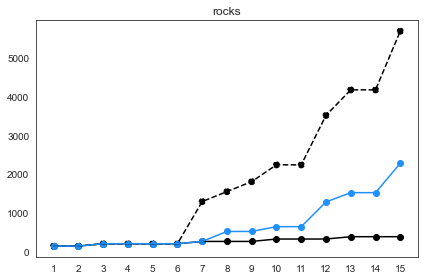

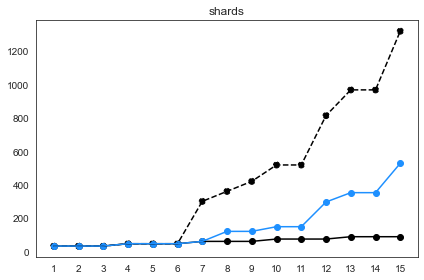

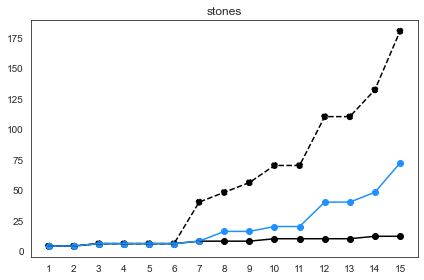

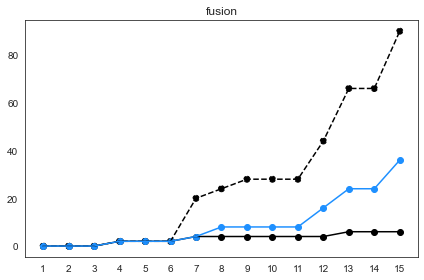

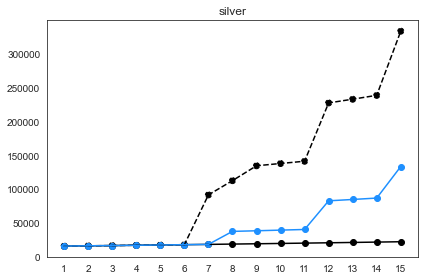

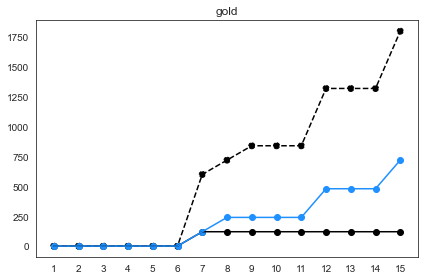

In [78]:
for resource in resources:
    fig, ax = plt.subplots(figsize=(6, 4))
    for stat, color, ls in [
        ('attempt_min', 'black', '-'),
        ('attempt_max', 'black', '--'),
        ('attempt_50%', 'dodgerblue', '-'),
    ]:
        totals = stats[stat] * weapon_costs[resource]
        ax.plot(stats['level'], totals, ls=ls, color=color, label=stat)
        ax.scatter(stats['level'], totals, ls=ls, color=color, label=stat)
        ax.set_title(resource)
    ax.set_xticks(range(stats.level.min(), stats.level.max() + 1))
    fig.tight_layout()
    plt.show()

Tabular view of costs per level

In [79]:
for resource in resources:
    print(resource)
    print(
        stats[['attempt_min', 'attempt_50%', 'attempt_max']]
        .multiply(weapon_costs[resource], axis=0)
        .set_index(stats.index + stats.level.min())
    )
    print()

rocks
    attempt_min  attempt_50%  attempt_max
1           138          138          138
2           138          138          138
3           198          198          198
4           198          198          198
5           198          198          198
6           198          198          198
7           258          258         1290
8           258          516         1548
9           258          516         1806
10          320          640         2240
11          320          640         2240
12          320         1280         3520
13          380         1520         4180
14          380         1520         4180
15          380         2280         5700

shards
    attempt_min  attempt_50%  attempt_max
1            32           32           32
2            32           32           32
3            32           32           32
4            46           46           46
5            46           46           46
6            46           46           46
7            60     

### Cumulative expected materials

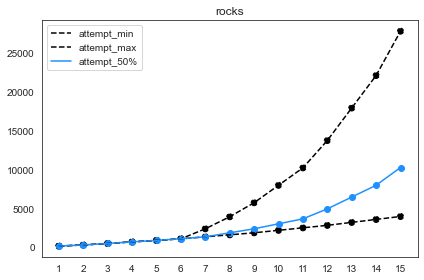

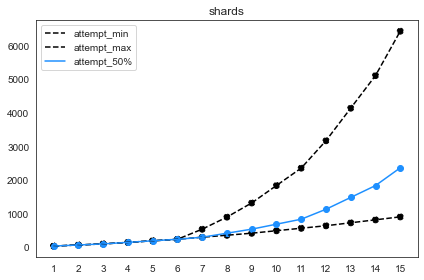

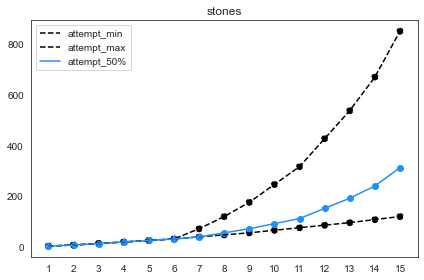

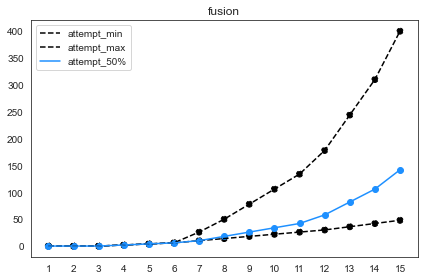

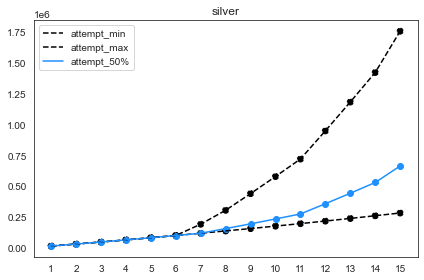

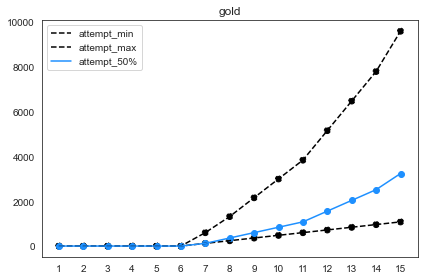

In [80]:
for resource in resources:
    fig, ax = plt.subplots(figsize=(6, 4))
    for stat, color, ls in [
        ('attempt_min', 'black', '--'),
        ('attempt_max', 'black', '--'),
        ('attempt_50%', 'dodgerblue', '-'),
    ]:
        cumm_totals = (stats[stat] * weapon_costs[resource]).cumsum()
        ax.plot(stats['level'], cumm_totals, label=stat, color=color, ls=ls)
        ax.scatter(stats['level'], cumm_totals, label=None, color=color, ls=ls)
        ax.set_title(resource)
    ax.legend()
    ax.set_xticks(range(stats.level.min(), stats.level.max() + 1))
    fig.tight_layout()
    plt.show()

Tabular view of cummulative costs

In [81]:
for resource in resources:
    print('Resource:', resource)
    print(
        stats[['attempt_min', 'attempt_50%', 'attempt_max']]
        .multiply(weapon_costs[resource], axis=0)
        .cumsum()
        .set_index(stats.index + stats.level.min())
    )
    print()

Resource: rocks
    attempt_min  attempt_50%  attempt_max
1           138          138          138
2           276          276          276
3           474          474          474
4           672          672          672
5           870          870          870
6          1068         1068         1068
7          1326         1326         2358
8          1584         1842         3906
9          1842         2358         5712
10         2162         2998         7952
11         2482         3638        10192
12         2802         4918        13712
13         3182         6438        17892
14         3562         7958        22072
15         3942        10238        27772

Resource: shards
    attempt_min  attempt_50%  attempt_max
1            32           32           32
2            64           64           64
3            96           96           96
4           142          142          142
5           188          188          188
6           234          234          234


## Gear Honing (single piece)

### Expected materials per level

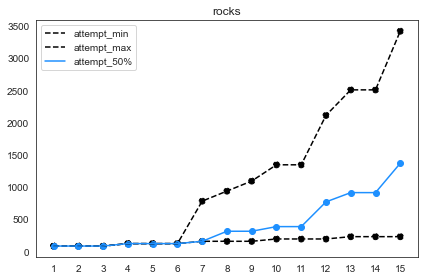

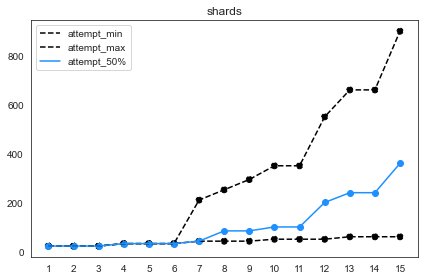

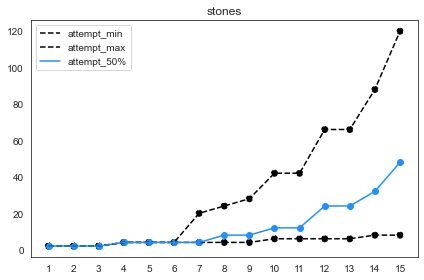

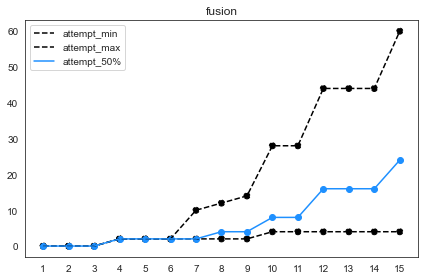

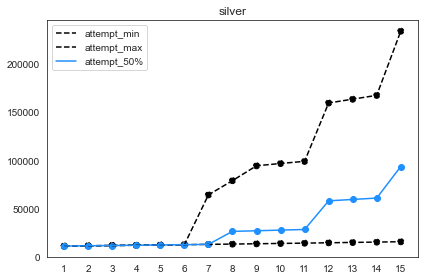

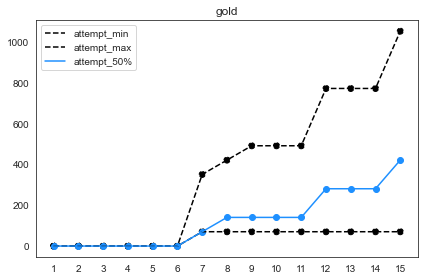

In [82]:
for resource in resources:
    fig, ax = plt.subplots(figsize=(6, 4))
    for stat, color, ls in [
        ('attempt_min', 'black', '--'),
        ('attempt_max', 'black', '--'),
        ('attempt_50%', 'dodgerblue', '-'),
    ]:
        totals = stats[stat] * gear_costs[resource]
        ax.plot(stats['level'], totals, ls=ls, color=color, label=stat)
        ax.scatter(stats['level'], totals, ls=ls, color=color, label=None)
        ax.set_title(resource)
    ax.legend()
    ax.set_xticks(range(stats.level.min(), stats.level.max() + 1))
    fig.tight_layout()
    plt.show()

In [83]:
for resource in resources:
    print('Resource:', resource)
    print(
        stats[['attempt_min', 'attempt_50%', 'attempt_max']]
        .multiply(gear_costs[resource], axis=0)
        .set_index(stats.index + stats.level.min())
    )
    print()

Resource: rocks
    attempt_min  attempt_50%  attempt_max
1            82           82           82
2            82           82           82
3            82           82           82
4           120          120          120
5           120          120          120
6           120          120          120
7           156          156          780
8           156          312          936
9           156          312         1092
10          192          384         1344
11          192          384         1344
12          192          768         2112
13          228          912         2508
14          228          912         2508
15          228         1368         3420

Resource: shards
    attempt_min  attempt_50%  attempt_max
1            22           22           22
2            22           22           22
3            22           22           22
4            32           32           32
5            32           32           32
6            32           32           32


### Cumulative expected resources

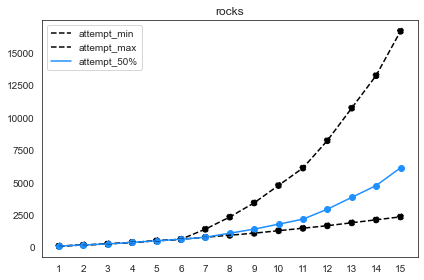

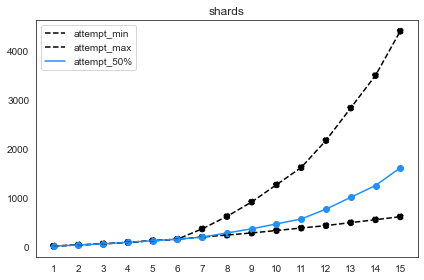

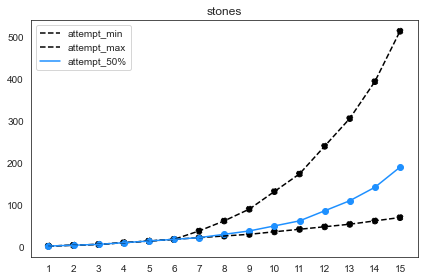

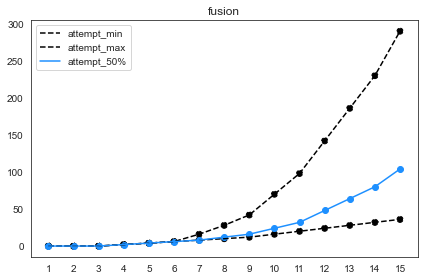

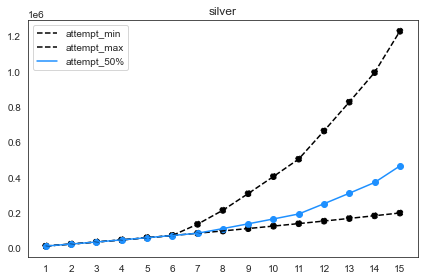

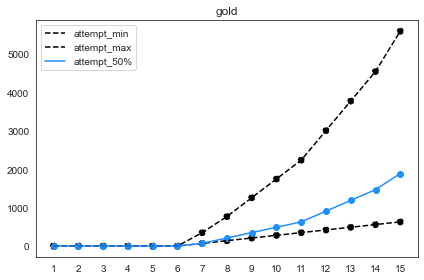

In [84]:
for resource in resources:
    fig, ax = plt.subplots(figsize=(6, 4))
    for stat, color, ls in [
        ('attempt_min', 'black', '--'),
        ('attempt_max', 'black', '--'),
        ('attempt_50%', 'dodgerblue', '-'),
    ]:
        totals = (stats[stat] * gear_costs[resource]).cumsum()
        ax.plot(stats['level'], totals, label=stat, color=color, ls=ls)
        ax.scatter(stats['level'], totals, label=None, color=color, ls=ls)
        ax.set_title(resource)
    ax.legend()
    ax.set_xticks(range(stats.level.min(), stats.level.max() + 1))
    fig.tight_layout()
    plt.show()

In [85]:
for resource in resources:
    print('Resource:', resource)
    print(
        stats[['attempt_min', 'attempt_50%', 'attempt_max']]
        .multiply(gear_costs[resource], axis=0)
        .cumsum()
        .set_index(stats.index + stats.level.min())
    )
    print()

Resource: rocks
    attempt_min  attempt_50%  attempt_max
1            82           82           82
2           164          164          164
3           246          246          246
4           366          366          366
5           486          486          486
6           606          606          606
7           762          762         1386
8           918         1074         2322
9          1074         1386         3414
10         1266         1770         4758
11         1458         2154         6102
12         1650         2922         8214
13         1878         3834        10722
14         2106         4746        13230
15         2334         6114        16650

Resource: shards
    attempt_min  attempt_50%  attempt_max
1            22           22           22
2            44           44           44
3            66           66           66
4            98           98           98
5           130          130          130
6           162          162          162


## Resource distributions (from simulation)

A look at the distribution of actual found costs from simulations (not simply using attempt percentiles).

### Weapon Costs

In [86]:
weapon_costs_per_sim = simulations.merge(weapon_costs, on='level')
for resource in resources:
    weapon_costs_per_sim[resource] *= weapon_costs_per_sim['attempt']
weapon_costs_per_sim

,trial,level,attempt,artisan_rate,rocks,shards,stones,fusion,silver,gold
0,1,1,1,1.0000,138,32,4,0,15860,0
1,2,1,1,1.0000,138,32,4,0,15860,0
2,3,1,1,1.0000,138,32,4,0,15860,0
3,4,1,1,1.0000,138,32,4,0,15860,0
4,5,1,1,1.0000,138,32,4,0,15860,0
...,...,...,...,...,...,...,...,...,...,...
1499995,99996,15,11,0.6740,4180,968,132,66,244860,1320
1499996,99997,15,7,0.3486,2660,616,84,42,155820,840
1499997,99998,15,5,0.2138,1900,440,60,30,111300,600
1499998,99999,15,1,0.0000,380,88,12,6,22260,120


In [87]:
weapon_costs_per_sim = (
    weapon_costs_per_sim
    .melt(
        id_vars=['trial', 'level'],
        value_vars=resources,
        var_name='resource',
        value_name='total'
    )
)
weapon_costs_per_sim

,trial,level,resource,total
0,1,1,rocks,138
1,2,1,rocks,138
2,3,1,rocks,138
3,4,1,rocks,138
4,5,1,rocks,138
...,...,...,...,...
8999995,99996,15,gold,1320
8999996,99997,15,gold,840
8999997,99998,15,gold,600
8999998,99999,15,gold,120


Weapon costs by level

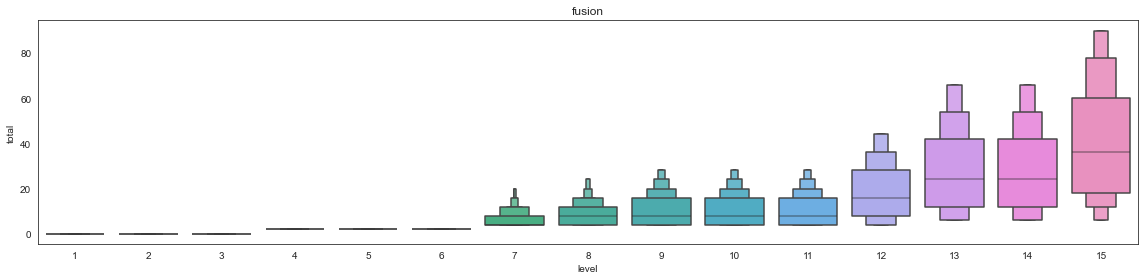

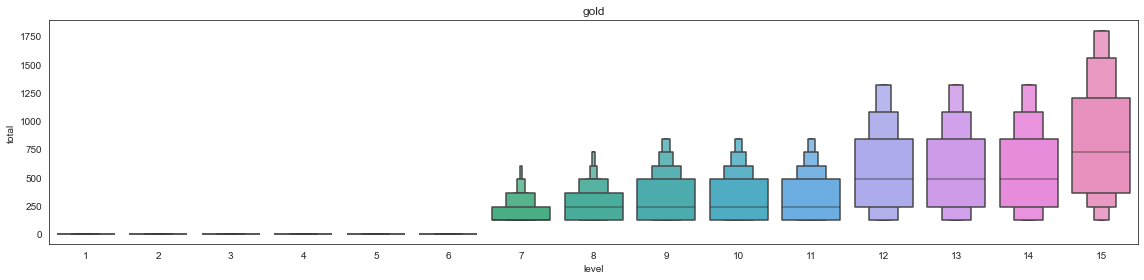

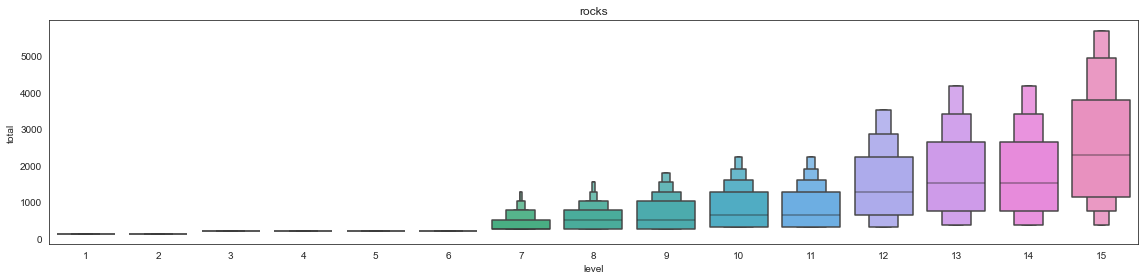

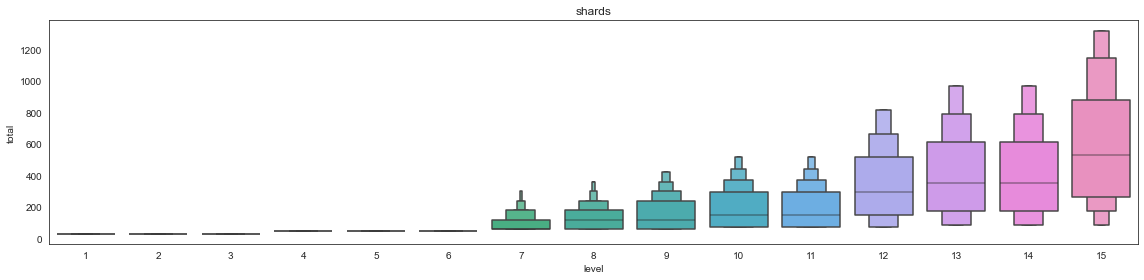

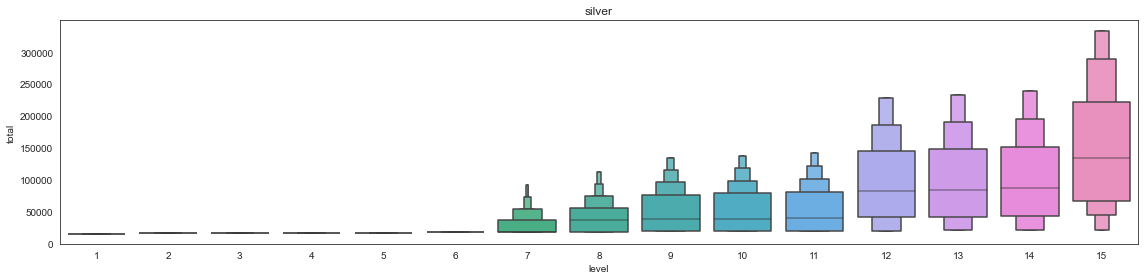

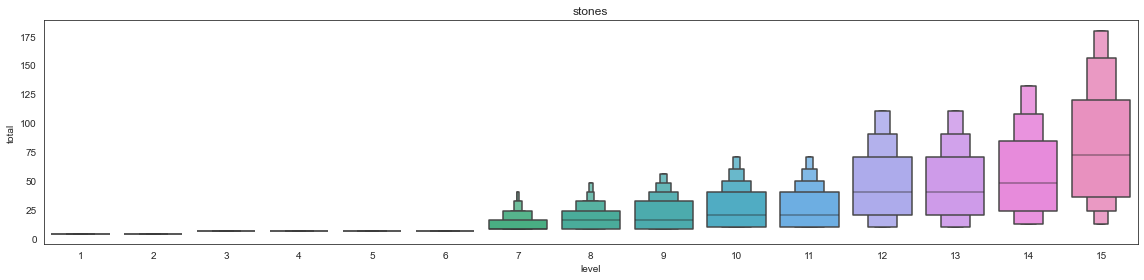

In [88]:
for res, gdf in weapon_costs_per_sim.groupby('resource'):
    fig, ax = plt.subplots(figsize=(16, 4))
    sb.boxenplot(data=gdf, x='level', y='total', ax=ax)
    plt.title(res)
    plt.tight_layout()
    plt.show()

Total weapon costs

In [89]:
totals = weapon_costs_per_sim.groupby(['trial', 'resource'])['total'].sum().reset_index()
totals

,trial,resource,total
0,1,fusion,176
1,1,gold,3960
2,1,rocks,12582
3,1,shards,2900
4,1,silver,794070
...,...,...,...
599995,100000,gold,2400
599996,100000,rocks,7516
599997,100000,shards,1728
599998,100000,silver,507130


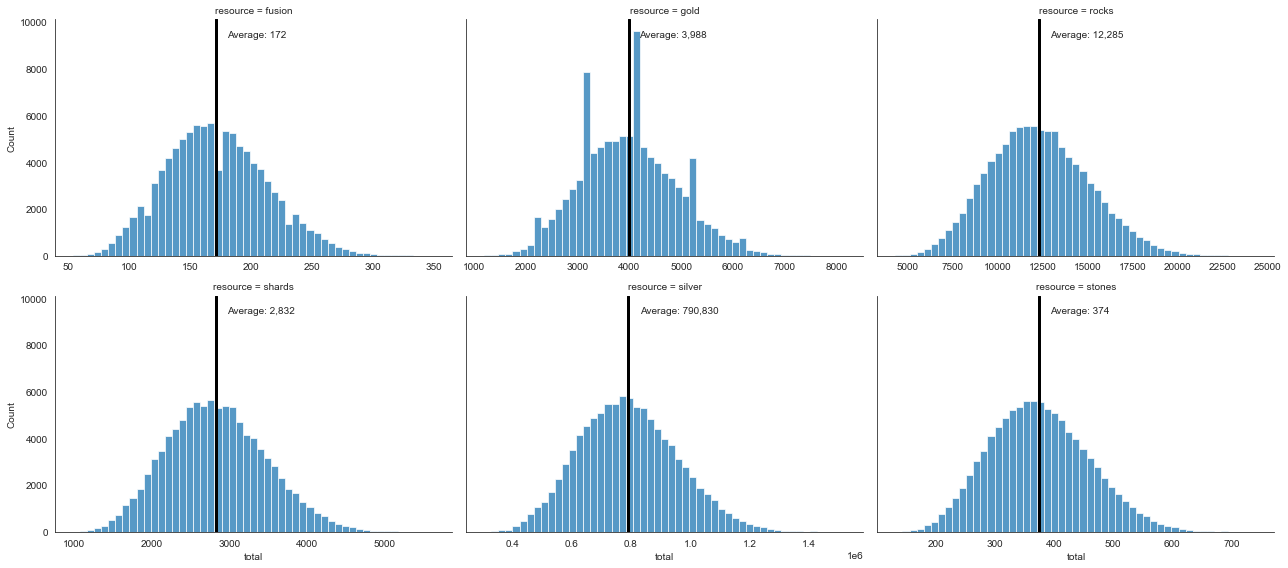

In [90]:
g = sb.FacetGrid(totals, col='resource', sharex=False, col_wrap=3, aspect=1.5, height=4)
g.map(sb.histplot, 'total', bins=51)
g.map(lambda x, **kw: plt.axvline(x.mean(), color="k", lw=3), 'total')
g.map(lambda x, **kwargs: plt.annotate(
    f'Average: {x.mean():,.0f}',
    xy=(x.mean()*1.05, .925),
    xycoords=plt.gca().get_xaxis_transform(),
    ha='left'
), 'total')

### Gear Costs (per piece)

In [91]:
gear_costs_per_sim = simulations.merge(gear_costs, on='level')
for resource in resources:
    gear_costs_per_sim[resource] *= gear_costs_per_sim['attempt']
gear_costs_per_sim

,trial,level,attempt,artisan_rate,rocks,shards,stones,fusion,silver,gold
0,1,1,1,1.0000,82,22,2,0,11100,0
1,2,1,1,1.0000,82,22,2,0,11100,0
2,3,1,1,1.0000,82,22,2,0,11100,0
3,4,1,1,1.0000,82,22,2,0,11100,0
4,5,1,1,1.0000,82,22,2,0,11100,0
...,...,...,...,...,...,...,...,...,...,...
1499995,99996,15,11,0.6740,2508,660,88,44,171600,770
1499996,99997,15,7,0.3486,1596,420,56,28,109200,490
1499997,99998,15,5,0.2138,1140,300,40,20,78000,350
1499998,99999,15,1,0.0000,228,60,8,4,15600,70


In [92]:
gear_costs_per_sim = (
    gear_costs_per_sim
    .melt(
        id_vars=['level', 'trial'],
        value_vars=resources,
        var_name='resource',
        value_name='total'
    )
)
gear_costs_per_sim

,level,trial,resource,total
0,1,1,rocks,82
1,1,2,rocks,82
2,1,3,rocks,82
3,1,4,rocks,82
4,1,5,rocks,82
...,...,...,...,...
8999995,15,99996,gold,770
8999996,15,99997,gold,490
8999997,15,99998,gold,350
8999998,15,99999,gold,70


By level

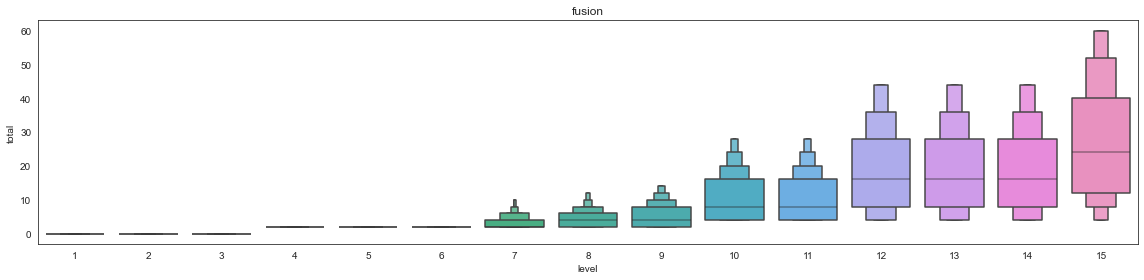

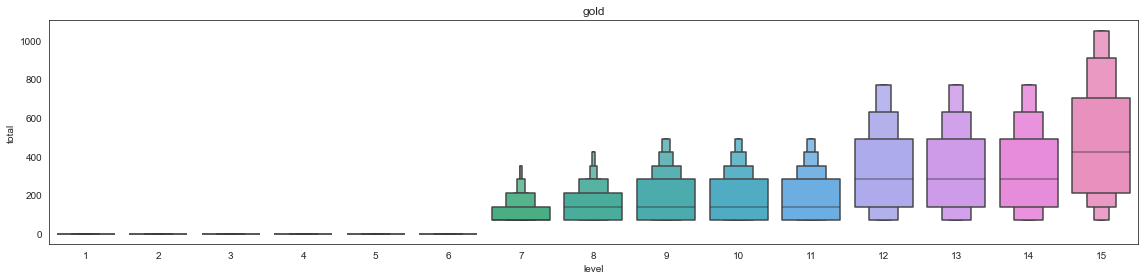

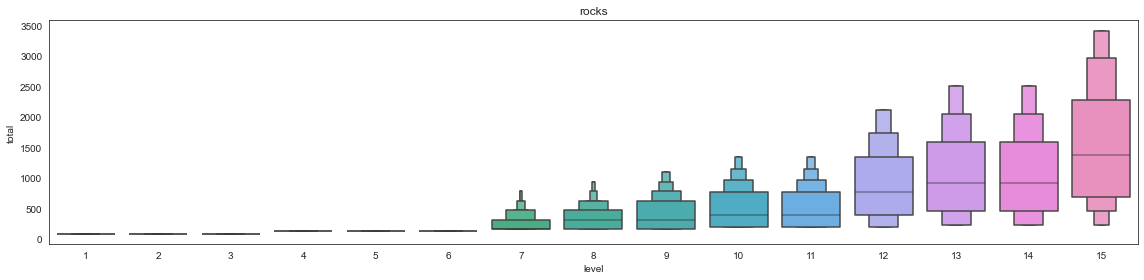

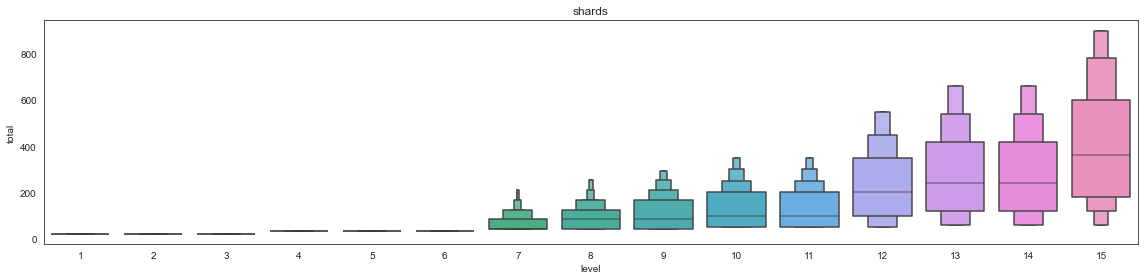

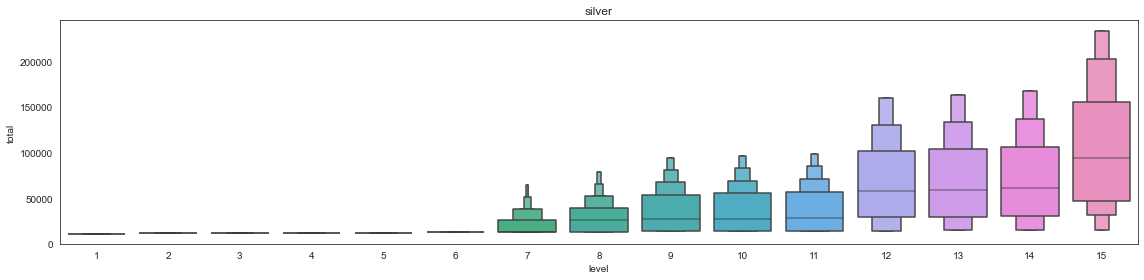

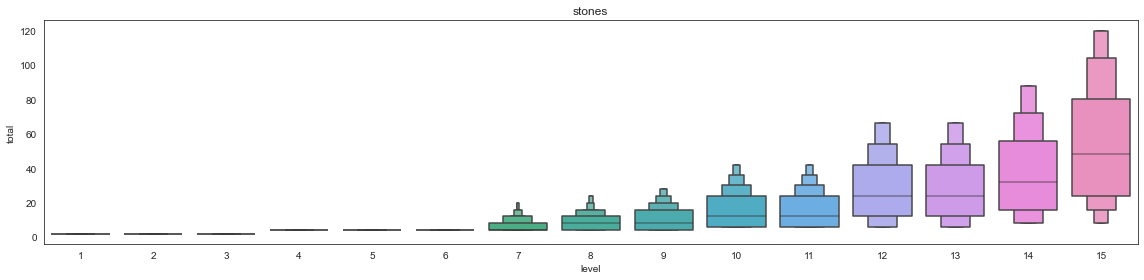

In [93]:
for res, gdf in gear_costs_per_sim.groupby('resource'):
    fig, ax = plt.subplots(figsize=(16, 4))
    sb.boxenplot(data=gdf, x='level', y='total', ax=ax)
    plt.title(res)
    plt.tight_layout()
    plt.show()

Total costs

In [94]:
totals = gear_costs_per_sim.groupby(['trial', 'resource'])['total'].sum().reset_index()
totals

,trial,resource,total
0,1,fusion,132
1,1,gold,2310
2,1,rocks,7518
3,1,shards,1978
4,1,silver,556480
...,...,...,...
599995,100000,gold,1400
599996,100000,rocks,4482
599997,100000,shards,1184
599998,100000,silver,355420


Text(0.5, 1.02, 'Gear Honing Totals')

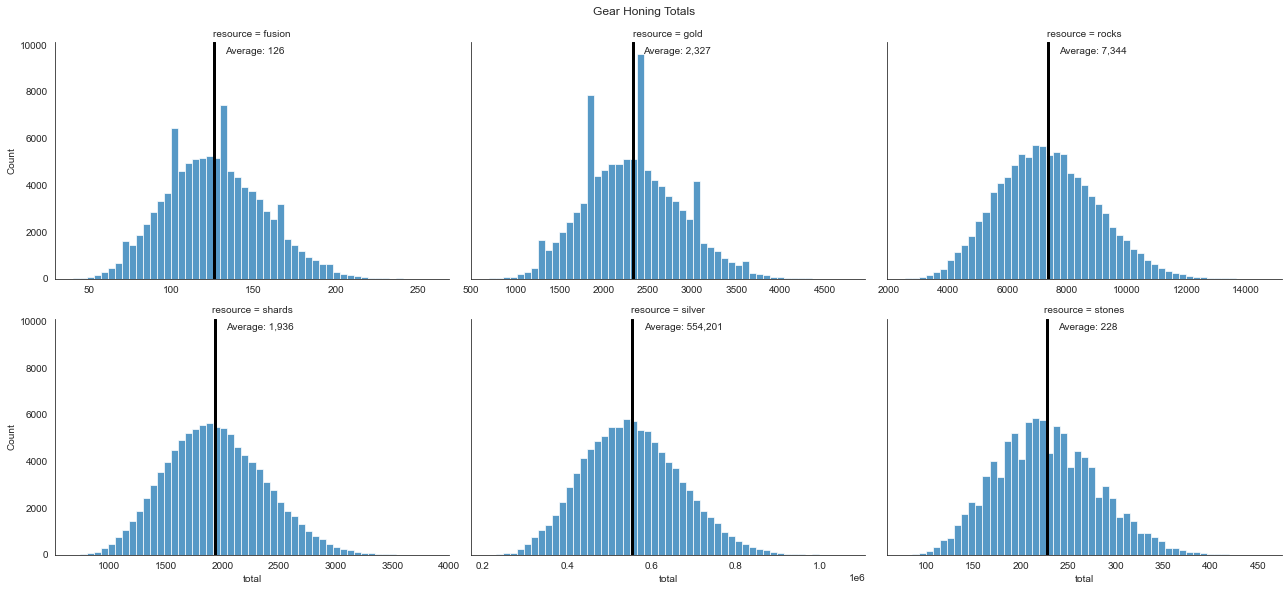

In [95]:
g = sb.FacetGrid(totals, col='resource', sharex=False, col_wrap=3, aspect=1.5, height=4)
g.map(sb.histplot, 'total', bins=51)
g.map(lambda x, **kw: plt.axvline(x.mean(), color="k", lw=3), 'total')
g.map(lambda x, **kwargs: plt.annotate(
    f'Average: {x.mean():,.0f}',
    xy=(x.mean()*1.05, .95),
    xycoords=plt.gca().get_xaxis_transform(),
    ha='left'
), 'total')
plt.suptitle('Gear Honing Totals', y=1.02)

# Tier 3b (1370 - 1490)

In [96]:
probs = pd.DataFrame(
    columns=('level', 'ilvl', 'base_rate'),
    data=[
        ( 7, 1375, 0.60),
        ( 8, 1380, 0.45),
        ( 9, 1385, 0.30),
        (10, 1390, 0.30),
        (11, 1395, 0.30),
        (12, 1400, 0.15),
        (13, 1405, 0.15),
        (14, 1410, 0.15),
        (15, 1415, 0.10),
        (16, 1430, 0.10),
        (17, 1445, 0.10),
        (18, 1460, 0.05),
        (19, 1475, 0.05),
        (20, 1490, 0.03),
    ]
)
probs

,level,ilvl,base_rate
0,7,1375,0.60
1,8,1380,0.45
2,9,1385,0.30
3,10,1390,0.30
4,11,1395,0.30
5,12,1400,0.15
6,13,1405,0.15
7,14,1410,0.15
8,15,1415,0.10
9,16,1430,0.10


In [97]:
gear_costs = pd.DataFrame(
    columns=('level', *resources),
    dtype=int,
    data=[
        ( 7, 404, 108,  8,  6, 22380, 170),
        ( 8, 404, 108, 10,  6, 22920, 170),
        ( 9, 404, 108, 10,  6, 23480, 170),
        (10, 498, 132, 10,  8, 24040, 170),
        (11, 498, 132, 10,  8, 24640, 170),
        (12, 498, 132, 12,  8, 25240, 170),
        (13, 592, 158, 12,  8, 25860, 170),
        (14, 592, 158, 12,  8, 26500, 170),
        (15, 592, 158, 12,  8, 27160, 180),
        (16, 686, 216, 14, 10, 27820, 210),
        (17, 686, 292, 16, 10, 28420, 250),
        (18, 686, 396, 16, 12, 29040, 280),
        (19, 780, 536, 18, 14, 29660, 320),
        (20, 780, 728, 20, 14, 30320, 350),
    ]
)
gear_costs

,level,rocks,shards,stones,fusion,silver,gold
0,7,404,108,8,6,22380,170
1,8,404,108,10,6,22920,170
2,9,404,108,10,6,23480,170
3,10,498,132,10,8,24040,170
4,11,498,132,10,8,24640,170
5,12,498,132,12,8,25240,170
6,13,592,158,12,8,25860,170
7,14,592,158,12,8,26500,170
8,15,592,158,12,8,27160,180
9,16,686,216,14,10,27820,210


In [98]:
weapon_costs = pd.DataFrame(
    columns=('level', *resources),
    dtype=int,
    data=[
        ( 7,  672,  156, 12,  6, 31920, 320),
        ( 8,  672,  156, 14,  6, 32700, 320),
        ( 9,  672,  156, 14,  8, 33520, 320),
        (10,  830,  192, 16,  8, 34340, 320),
        (11,  830,  192, 16,  8, 35180, 330),
        (12,  830,  192, 18,  8, 36040, 330),
        (13,  968,  228, 18, 10, 36940, 330),
        (14,  968,  228, 20, 10, 37840, 330),
        (15,  968,  228, 20, 10, 38760, 330),
        (16, 1144,  310, 22, 12, 39720, 410),
        (17, 1144,  422, 24, 14, 40580, 480),
        (18, 1144,  572, 28, 16, 41460, 540),
        (19, 1300,  776, 30, 18, 42360, 640),
        (20, 1300, 1054, 32, 20, 43260, 730),
    ]
)
weapon_costs

,level,rocks,shards,stones,fusion,silver,gold
0,7,672,156,12,6,31920,320
1,8,672,156,14,6,32700,320
2,9,672,156,14,8,33520,320
3,10,830,192,16,8,34340,320
4,11,830,192,16,8,35180,330
5,12,830,192,18,8,36040,330
6,13,968,228,18,10,36940,330
7,14,968,228,20,10,37840,330
8,15,968,228,20,10,38760,330
9,16,1144,310,22,12,39720,410


In [99]:
rates = rates_table(probs)
rates.level = rates.level.astype('int')
rates

,level,attempt,artisan_rate,success_rate
0,7,1,0.0000,0.60
1,7,2,0.2790,0.66
2,7,3,0.5859,0.72
3,7,4,0.9207,0.78
4,7,5,1.0000,1.00
...,...,...,...,...
197,20,36,0.8996,0.06
198,20,37,0.9275,0.06
199,20,38,0.9554,0.06
200,20,39,0.9833,0.06


Since each roll is independent, can easily simulate using pandas by repeating the probs table, adding a random uniform column, and selecting the first success from each trial/level grouping.

In [100]:
simulations = (
    pd.concat([
        rates.assign(trial=i+1)
        for i in range(num_simulations)
    ])
    .assign(roll=np.random.uniform(size=rates.shape[0]*num_simulations))
    .query('roll < success_rate')
    .drop(['roll', 'success_rate'], axis=1)
    .groupby(['trial', 'level'], as_index=False)
    .first()
)

This provides a number of simulations of honing level 1-15 and how many attempts until success for each level.

In [101]:
simulations.pivot(index='trial', columns='level', values='attempt')

level,7,8,9,10,11,12,13,14,15,16,17,18,19,20
trial,,,,,,,,,,,,,,
1,1,1,5,3,2,10,5,2,4,7,14,13,2,11
2,4,3,1,5,3,2,11,11,2,1,15,11,3,10
3,1,1,2,4,1,1,2,2,14,7,5,1,2,40
4,1,2,1,2,1,6,3,6,8,15,6,16,15,40
5,3,3,1,2,4,2,10,9,6,4,1,17,8,27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99996,1,1,3,3,1,4,1,2,9,9,4,2,9,2
99997,2,1,2,5,7,2,11,6,4,10,10,15,7,7
99998,1,1,3,1,4,3,3,7,13,15,3,2,10,4


A look at distributions of attempts by level

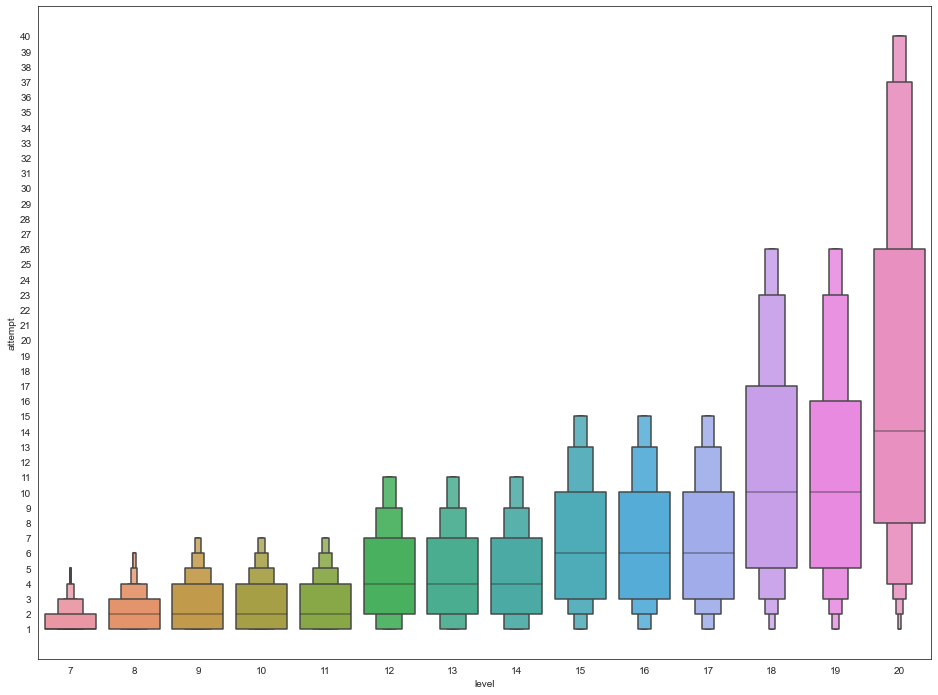

In [102]:
fig, ax = plt.subplots(figsize=(16,12))
sb.boxenplot(data=simulations, x='level', y='attempt', ax=ax);
ax.set_yticks(range(1, simulations.attempt.max()+1));

Breaking down each level individually

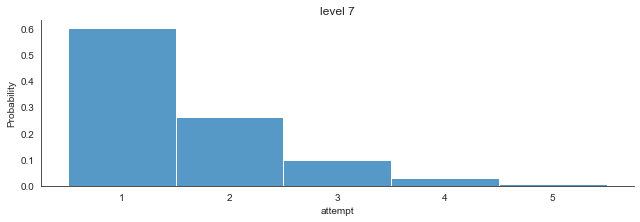

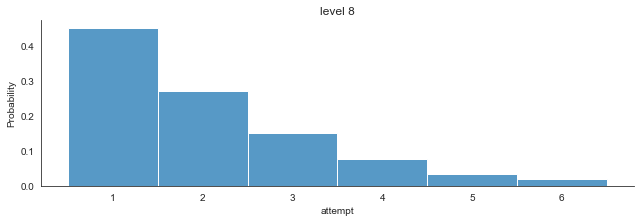

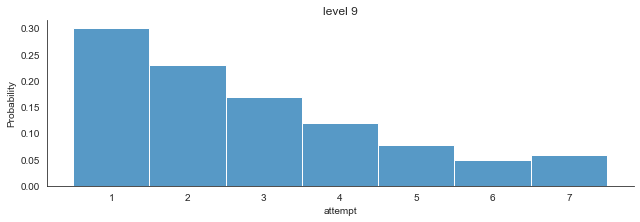

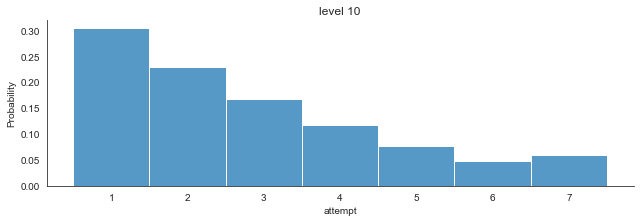

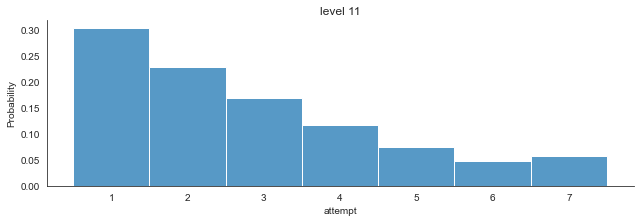

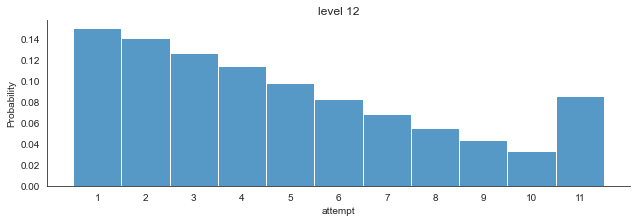

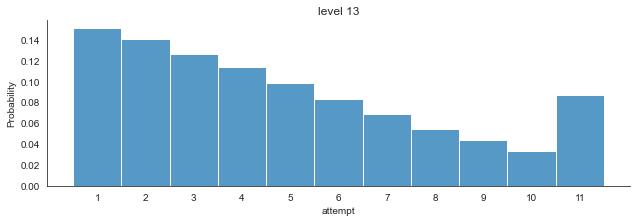

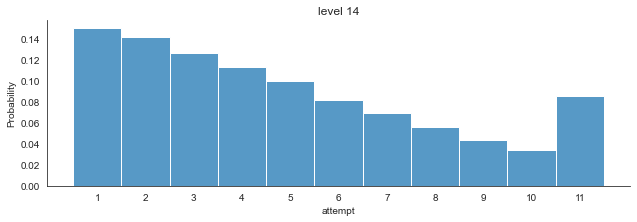

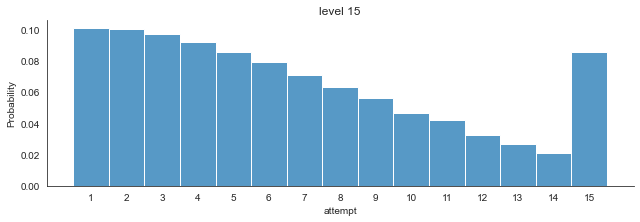

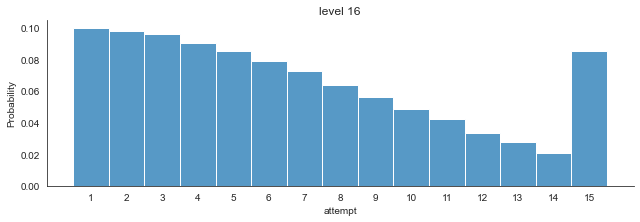

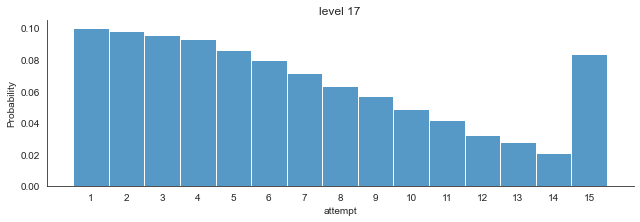

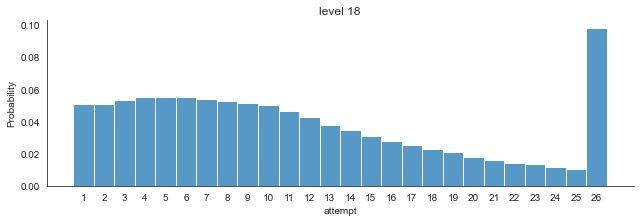

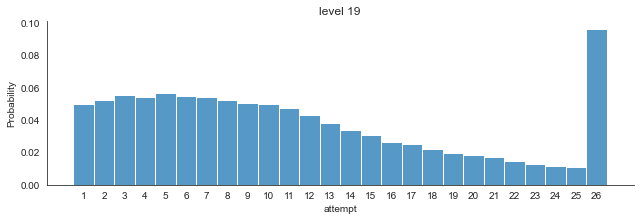

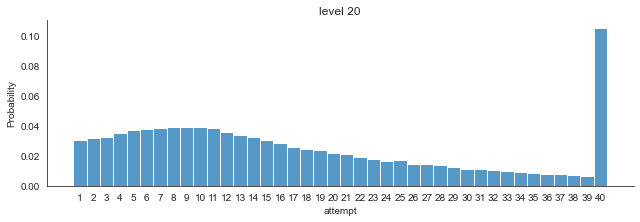

In [103]:
for level, gdf in simulations.query('level >= 7').groupby('level'):
    sb.displot(gdf, x='attempt', discrete=True, stat='probability', aspect=3, height=3)
    plt.tight_layout()
    plt.title(f'level {level}')
    plt.xticks(range(1, gdf.attempt.max() + 1))

A look at the cumulative success probabilities by level/attempt

In [104]:
(
    (
        simulations[['level', 'attempt']]
        .groupby('level')
        .value_counts()
        .div(num_simulations)
    )
    .reset_index()
    .rename({0: 'p'}, axis=1)
    .pivot(index='level', columns='attempt')
    .apply(np.cumsum, axis=1)
    .applymap(lambda p: np.round(p, 2))
    .fillna('--')
)

p                                                        ...  \
attempt    1     2     3     4     5     6     7     8     9     10  ...   
level                                                                ...   
7        0.60  0.86  0.96  0.99  1.00    --    --    --    --    --  ...   
8        0.45  0.72  0.87  0.95  0.98   1.0    --    --    --    --  ...   
9        0.30  0.53  0.70  0.82  0.89  0.94   1.0    --    --    --  ...   
10       0.30  0.53  0.70  0.82  0.89  0.94   1.0    --    --    --  ...   
11       0.30  0.53  0.70  0.82  0.89  0.94   1.0    --    --    --  ...   
12       0.15  0.29  0.42  0.53  0.63  0.71  0.78  0.84  0.88  0.91  ...   
13       0.15  0.29  0.42  0.53  0.63  0.71  0.78  0.84  0.88  0.91  ...   
14       0.15  0.29  0.42  0.53  0.63  0.71  0.78  0.84  0.88  0.91  ...   
15       0.10  0.20  0.30  0.39  0.48  0.55  0.63  0.69  0.75  0.79  ...   
16       0.10  0.20  0.29  0.38  0.47  0.55  0.62  0.69  0.74  0.79  ...   
17       0.10  0.20  0.29  0.39  0.47  0.55  0.63  0.69  0.75  0.79  ...   
18       0.05  0.10  0.16  0.21  0.27  0.32  0.37  0.43  0.48  0.53  ...   
19       0.05  0.10  0.16  0.21  0.27  0.32  0.38  0.43  0.48  0.53  ...   
20       0.03  0.06  0.09  0.13  0.17  0.21  0.24  0.28  0.32  0.36  ...   

                                                                    
attempt    31    32    33    34    35    36    37    38    39   40  
level                                                               
7          --    --    --    --    --    --    --    --    --   --  
8          --    --    --    --    --    --    --    --    --   --  
9          --    --    --    --    --    --    --    --    --   --  
10         --    --    --    --    --    --    --    --    --   --  
11         --    --    --    --    --    --    --    --    --   --  
12         --    --    --    --    --    --    --    --    --   --  
13         --    --    --    --    --    --    --    --    --   --  
14         --    --    --    --    --    --    --    --    --   --  
15         --    --    --    --    --    --    --    --    --   --  
16         --    --    --    --    --    --    --    --    --   --  
17         --    --    --    --    --    --    --    --    --   --  
18         --    --    --    --    --    --    --    --    --   --  
19         --    --    --    --    --    --    --    --    --   --  
20       0.83  0.84  0.85  0.86  0.87  0.87  0.88  0.89  0.89  1.0  

[14 rows x 40 columns]

Inverting gives the failure rates by level (i.e. what percentage of players will fail attempt X)

In [105]:
(
    (
        simulations[['level', 'attempt']]
        .groupby('level')
        .value_counts()
        .div(num_simulations)
    )
    .reset_index()
    .rename({0: 'p'}, axis=1)
    .pivot(index='level', columns='attempt')
    .apply(np.cumsum, axis=1)
    .applymap(lambda p: np.round(p, 2))
    .applymap(lambda p: 1-p)
    .fillna('--')
)

p                                                        ...  \
attempt    1     2     3     4     5     6     7     8     9     10  ...   
level                                                                ...   
7        0.40  0.14  0.04  0.01  0.00    --    --    --    --    --  ...   
8        0.55  0.28  0.13  0.05  0.02   0.0    --    --    --    --  ...   
9        0.70  0.47  0.30  0.18  0.11  0.06   0.0    --    --    --  ...   
10       0.70  0.47  0.30  0.18  0.11  0.06   0.0    --    --    --  ...   
11       0.70  0.47  0.30  0.18  0.11  0.06   0.0    --    --    --  ...   
12       0.85  0.71  0.58  0.47  0.37  0.29  0.22  0.16  0.12  0.09  ...   
13       0.85  0.71  0.58  0.47  0.37  0.29  0.22  0.16  0.12  0.09  ...   
14       0.85  0.71  0.58  0.47  0.37  0.29  0.22  0.16  0.12  0.09  ...   
15       0.90  0.80  0.70  0.61  0.52  0.45  0.37  0.31  0.25  0.21  ...   
16       0.90  0.80  0.71  0.62  0.53  0.45  0.38  0.31  0.26  0.21  ...   
17       0.90  0.80  0.71  0.61  0.53  0.45  0.37  0.31  0.25  0.21  ...   
18       0.95  0.90  0.84  0.79  0.73  0.68  0.63  0.57  0.52  0.47  ...   
19       0.95  0.90  0.84  0.79  0.73  0.68  0.62  0.57  0.52  0.47  ...   
20       0.97  0.94  0.91  0.87  0.83  0.79  0.76  0.72  0.68  0.64  ...   

                                                                    
attempt    31    32    33    34    35    36    37    38    39   40  
level                                                               
7          --    --    --    --    --    --    --    --    --   --  
8          --    --    --    --    --    --    --    --    --   --  
9          --    --    --    --    --    --    --    --    --   --  
10         --    --    --    --    --    --    --    --    --   --  
11         --    --    --    --    --    --    --    --    --   --  
12         --    --    --    --    --    --    --    --    --   --  
13         --    --    --    --    --    --    --    --    --   --  
14         --    --    --    --    --    --    --    --    --   --  
15         --    --    --    --    --    --    --    --    --   --  
16         --    --    --    --    --    --    --    --    --   --  
17         --    --    --    --    --    --    --    --    --   --  
18         --    --    --    --    --    --    --    --    --   --  
19         --    --    --    --    --    --    --    --    --   --  
20       0.17  0.16  0.15  0.14  0.13  0.13  0.12  0.11  0.11  0.0  

[14 rows x 40 columns]

A naive look at expected attempts per level using simple percentiles

In [106]:
stats = (
    simulations[['level', 'attempt']]
    .groupby('level')
    .describe(percentiles=[0.5])
)
stats.columns = ['_'.join(col) for col in stats.columns.to_flat_index()]
stats = (
    stats
    .reset_index()
    .drop(['attempt_count', 'attempt_mean', 'attempt_std'] , axis=1)
    .astype(int)
)
stats.T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
level,7,8,9,10,11,12,13,14,15,16,17,18,19,20
attempt_min,1,1,1,1,1,1,1,1,1,1,1,1,1,1
attempt_50%,1,2,2,2,2,4,4,4,6,6,6,10,10,14
attempt_max,5,6,7,7,7,11,11,11,15,15,15,26,26,40


## Weapon Honing

### Expected materials per level

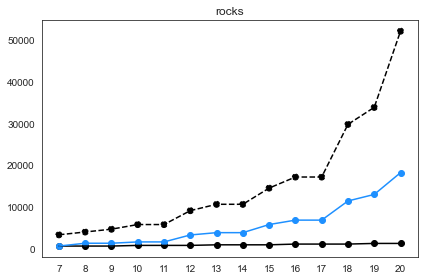

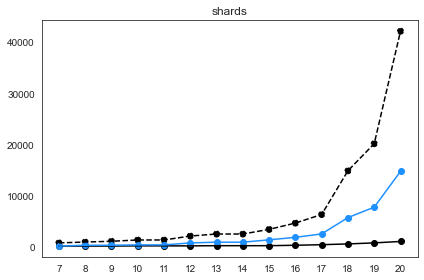

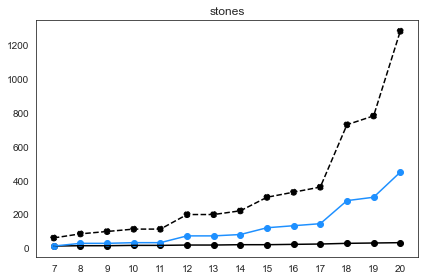

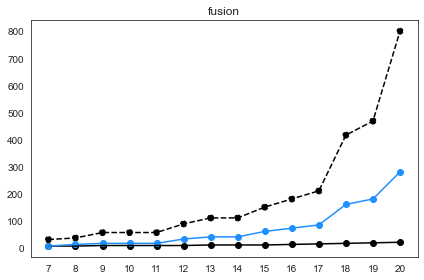

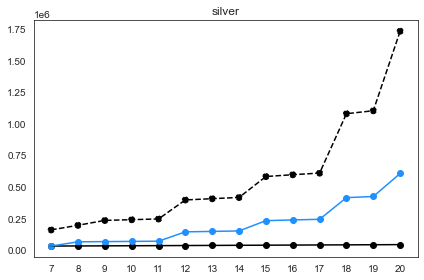

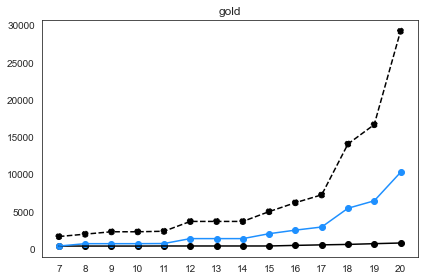

In [107]:
for resource in resources:
    fig, ax = plt.subplots(figsize=(6, 4))
    for stat, color, ls in [
        ('attempt_min', 'black', '-'),
        ('attempt_max', 'black', '--'),
        ('attempt_50%', 'dodgerblue', '-'),
    ]:
        totals = stats[stat] * weapon_costs[resource]
        ax.plot(stats['level'], totals, ls=ls, color=color, label=stat)
        ax.scatter(stats['level'], totals, ls=ls, color=color, label=stat)
        ax.set_title(resource)
    ax.set_xticks(range(stats.level.min(), stats.level.max() + 1))
    fig.tight_layout()
    plt.show()

Tabular view of costs per level

In [108]:
for resource in resources:
    print(resource)
    print(
        stats[['attempt_min', 'attempt_50%', 'attempt_max']]
        .multiply(weapon_costs[resource], axis=0)
        .set_index(stats.index + stats.level.min())
    )
    print()

rocks
    attempt_min  attempt_50%  attempt_max
7           672          672         3360
8           672         1344         4032
9           672         1344         4704
10          830         1660         5810
11          830         1660         5810
12          830         3320         9130
13          968         3872        10648
14          968         3872        10648
15          968         5808        14520
16         1144         6864        17160
17         1144         6864        17160
18         1144        11440        29744
19         1300        13000        33800
20         1300        18200        52000

shards
    attempt_min  attempt_50%  attempt_max
7           156          156          780
8           156          312          936
9           156          312         1092
10          192          384         1344
11          192          384         1344
12          192          768         2112
13          228          912         2508
14          228     

### Cumulative expected materials

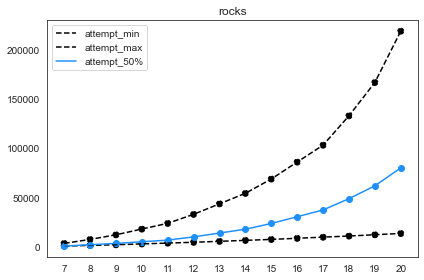

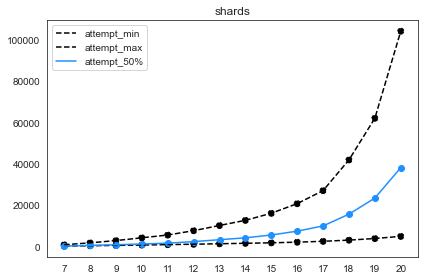

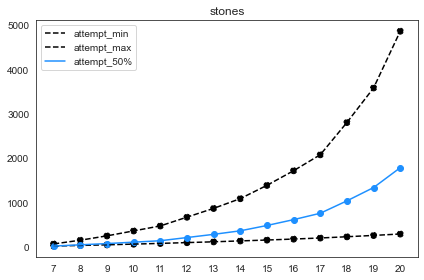

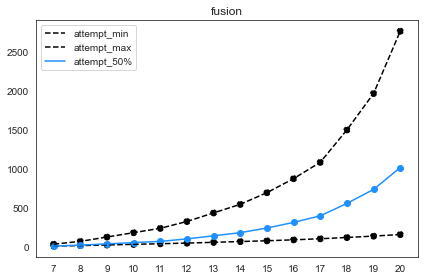

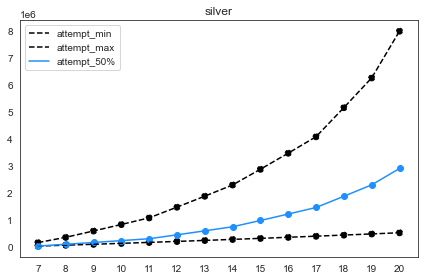

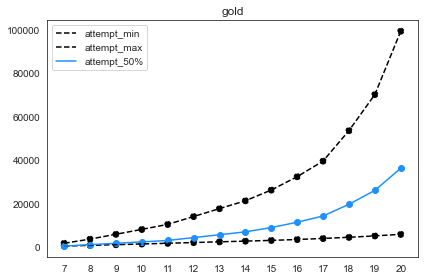

In [109]:
for resource in resources:
    fig, ax = plt.subplots(figsize=(6, 4))
    for stat, color, ls in [
        ('attempt_min', 'black', '--'),
        ('attempt_max', 'black', '--'),
        ('attempt_50%', 'dodgerblue', '-'),
    ]:
        cumm_totals = (stats[stat] * weapon_costs[resource]).cumsum()
        ax.plot(stats['level'], cumm_totals, label=stat, color=color, ls=ls)
        ax.scatter(stats['level'], cumm_totals, label=None, color=color, ls=ls)
        ax.set_title(resource)
    ax.legend()
    ax.set_xticks(range(stats.level.min(), stats.level.max() + 1))
    fig.tight_layout()
    plt.show()

Tabular view of cummulative costs

In [110]:
for resource in resources:
    print('Resource:', resource)
    print(
        stats[['attempt_min', 'attempt_50%', 'attempt_max']]
        .multiply(weapon_costs[resource], axis=0)
        .cumsum()
        .set_index(stats.index + stats.level.min())
    )
    print()

Resource: rocks
    attempt_min  attempt_50%  attempt_max
7           672          672         3360
8          1344         2016         7392
9          2016         3360        12096
10         2846         5020        17906
11         3676         6680        23716
12         4506        10000        32846
13         5474        13872        43494
14         6442        17744        54142
15         7410        23552        68662
16         8554        30416        85822
17         9698        37280       102982
18        10842        48720       132726
19        12142        61720       166526
20        13442        79920       218526

Resource: shards
    attempt_min  attempt_50%  attempt_max
7           156          156          780
8           312          468         1716
9           468          780         2808
10          660         1164         4152
11          852         1548         5496
12         1044         2316         7608
13         1272         3228        10116


## Gear Honing (single piece)

### Expected materials per level

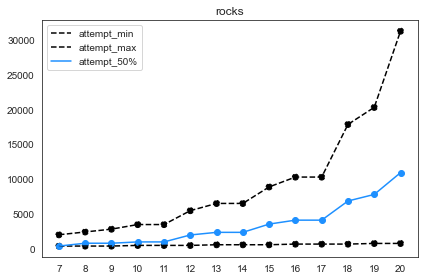

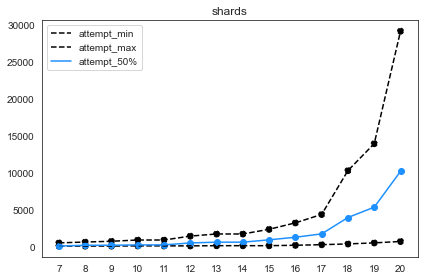

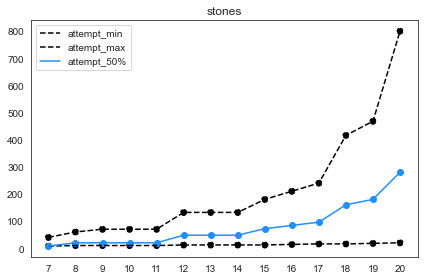

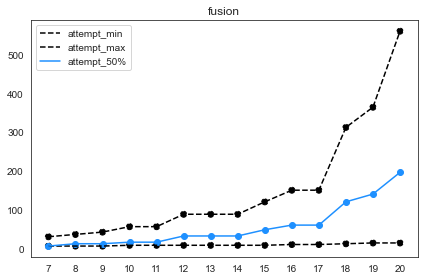

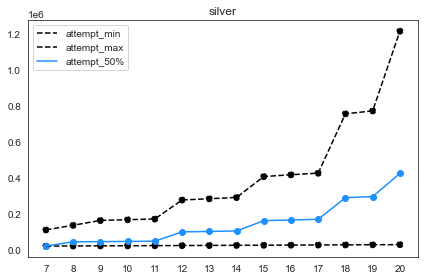

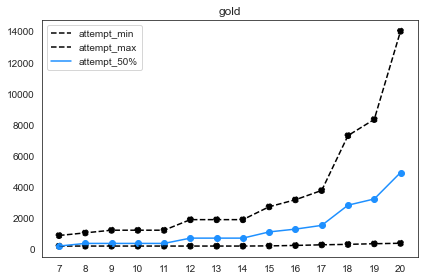

In [111]:
for resource in resources:
    fig, ax = plt.subplots(figsize=(6, 4))
    for stat, color, ls in [
        ('attempt_min', 'black', '--'),
        ('attempt_max', 'black', '--'),
        ('attempt_50%', 'dodgerblue', '-'),
    ]:
        totals = stats[stat] * gear_costs[resource]
        ax.plot(stats['level'], totals, ls=ls, color=color, label=stat)
        ax.scatter(stats['level'], totals, ls=ls, color=color, label=None)
        ax.set_title(resource)
    ax.legend()
    ax.set_xticks(range(stats.level.min(), stats.level.max() + 1))
    fig.tight_layout()
    plt.show()

In [112]:
for resource in resources:
    print('Resource:', resource)
    print(
        stats[['attempt_min', 'attempt_50%', 'attempt_max']]
        .multiply(gear_costs[resource], axis=0)
        .set_index(stats.index+1)
    )
    print()

Resource: rocks
    attempt_min  attempt_50%  attempt_max
1           404          404         2020
2           404          808         2424
3           404          808         2828
4           498          996         3486
5           498          996         3486
6           498         1992         5478
7           592         2368         6512
8           592         2368         6512
9           592         3552         8880
10          686         4116        10290
11          686         4116        10290
12          686         6860        17836
13          780         7800        20280
14          780        10920        31200

Resource: shards
    attempt_min  attempt_50%  attempt_max
1           108          108          540
2           108          216          648
3           108          216          756
4           132          264          924
5           132          264          924
6           132          528         1452
7           158          632         1738


### Cumulative expected materials

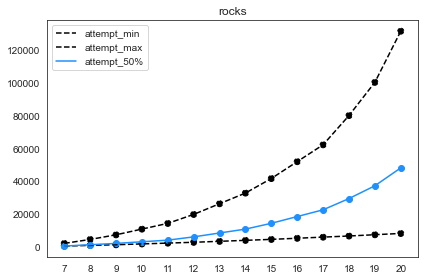

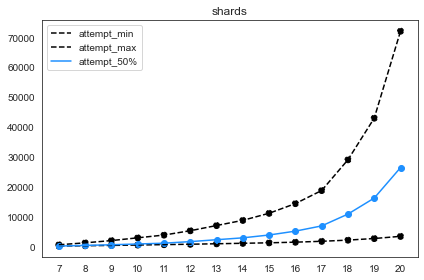

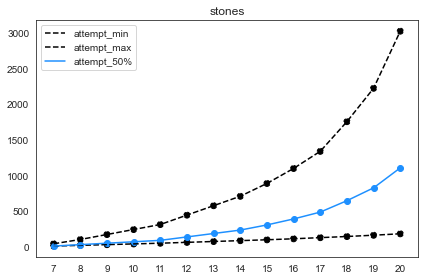

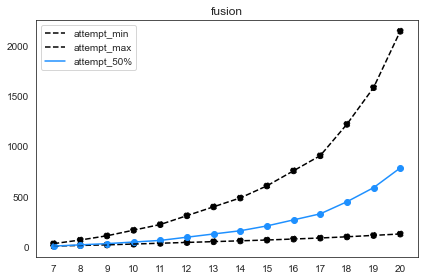

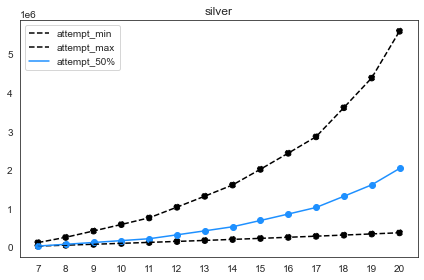

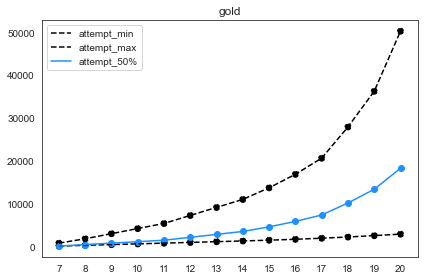

In [113]:
for resource in resources:
    fig, ax = plt.subplots(figsize=(6, 4))
    for stat, color, ls in [
        ('attempt_min', 'black', '--'),
        ('attempt_max', 'black', '--'),
        ('attempt_50%', 'dodgerblue', '-'),
    ]:
        totals = (stats[stat] * gear_costs[resource]).cumsum()
        ax.plot(stats['level'], totals, label=stat, color=color, ls=ls)
        ax.scatter(stats['level'], totals, label=None, color=color, ls=ls)
        ax.set_title(resource)
    ax.legend()
    ax.set_xticks(range(stats.level.min(), stats.level.max() + 1))
    fig.tight_layout()
    plt.show()

In [126]:
for resource in resources:
    print('Resource:', resource)
    print(
        stats[['attempt_min', 'attempt_50%', 'attempt_max']]
        .multiply(gear_costs[resource], axis=0)
        .cumsum()
        .set_index(stats.index + stats.level.min())
    )
    print()

Resource: rocks
    attempt_min  attempt_50%  attempt_max
7           404          404         2020
8           808         1212         4444
9          1212         2020         7272
10         1710         3016        10758
11         2208         4012        14244
12         2706         6004        19722
13         3298         8372        26234
14         3890        10740        32746
15         4482        14292        41626
16         5168        18408        51916
17         5854        22524        62206
18         6540        29384        80042
19         7320        37184       100322
20         8100        48104       131522

Resource: shards
    attempt_min  attempt_50%  attempt_max
7           108          108          540
8           216          324         1188
9           324          540         1944
10          456          804         2868
11          588         1068         3792
12          720         1596         5244
13          878         2228         6982


## Resource Distributions (from simulation)

A look at the distribution of actual found costs from simulations (not simply using attempt percentiles).

### Weapon Costs

In [127]:
weapon_costs_per_sim = simulations.merge(weapon_costs, on='level')
for resource in resources:
    weapon_costs_per_sim[resource] *= weapon_costs_per_sim['attempt']
weapon_costs_per_sim

,trial,level,attempt,artisan_rate,rocks,shards,stones,fusion,silver,gold
0,1,7,1,0.0000,672,156,12,6,31920,320
1,2,7,4,0.9207,2688,624,48,24,127680,1280
2,3,7,1,0.0000,672,156,12,6,31920,320
3,4,7,1,0.0000,672,156,12,6,31920,320
4,5,7,3,0.5859,2016,468,36,18,95760,960
...,...,...,...,...,...,...,...,...,...,...
1399995,99996,20,2,0.0140,2600,2108,64,40,86520,1460
1399996,99997,20,7,0.1045,9100,7378,224,140,302820,5110
1399997,99998,20,4,0.0460,5200,4216,128,80,173040,2920
1399998,99999,20,18,0.3974,23400,18972,576,360,778680,13140


In [128]:
weapon_costs_per_sim = (
    weapon_costs_per_sim
    .melt(
        id_vars=['trial', 'level'],
        value_vars=resources,
        var_name='resource',
        value_name='total'
    )
)
weapon_costs_per_sim

,trial,level,resource,total
0,1,7,rocks,672
1,2,7,rocks,2688
2,3,7,rocks,672
3,4,7,rocks,672
4,5,7,rocks,2016
...,...,...,...,...
8399995,99996,20,gold,1460
8399996,99997,20,gold,5110
8399997,99998,20,gold,2920
8399998,99999,20,gold,13140


Weapon costs by level

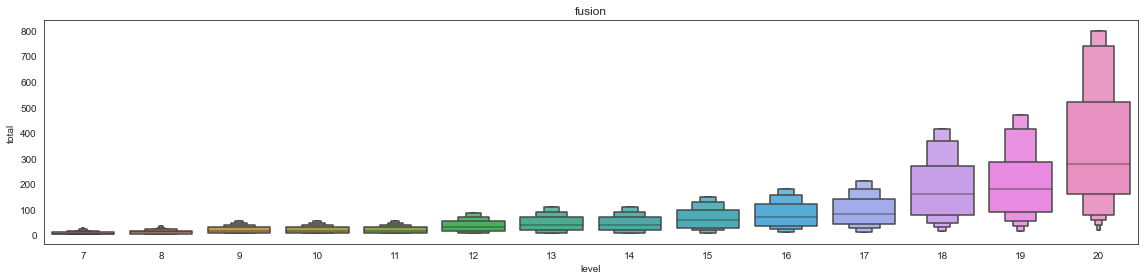

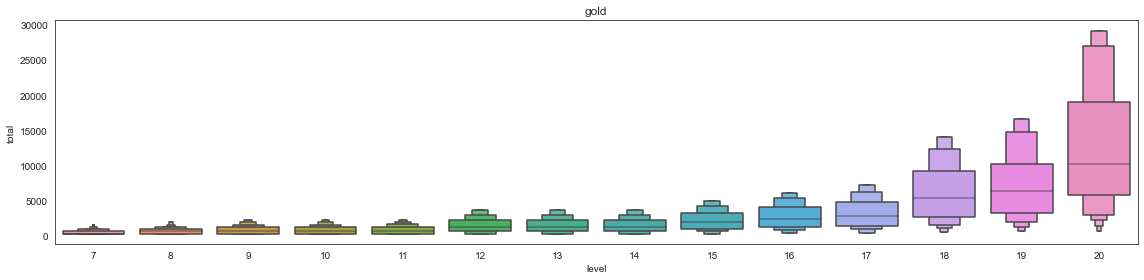

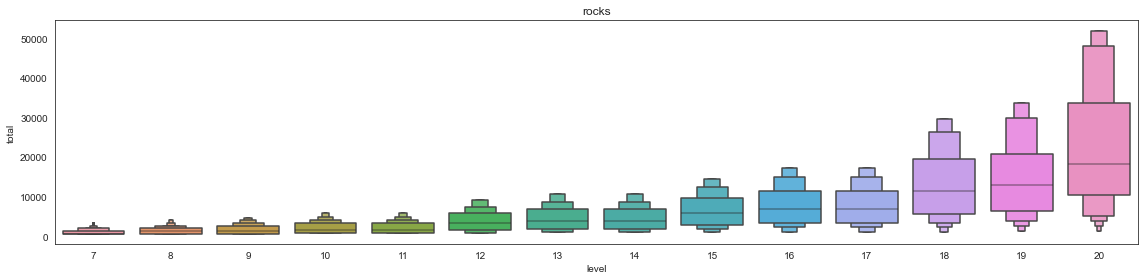

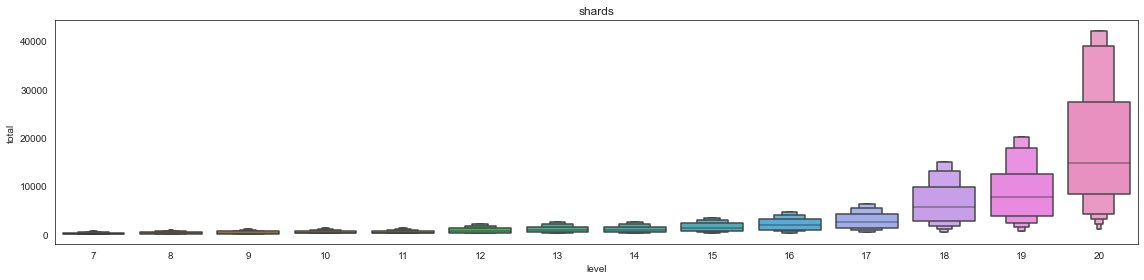

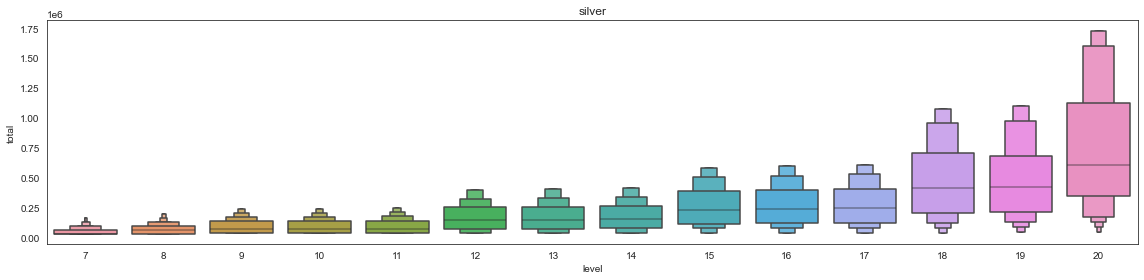

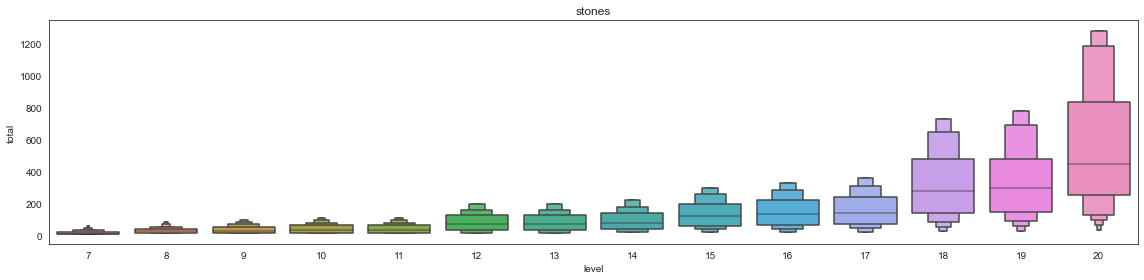

In [129]:
for res, gdf in weapon_costs_per_sim.groupby('resource'):
    fig, ax = plt.subplots(figsize=(16, 4))
    sb.boxenplot(data=gdf, x='level', y='total', ax=ax)
    plt.title(res)
    plt.tight_layout()
    plt.show()

Total weapon costs

In [130]:
totals = weapon_costs_per_sim.groupby(['trial', 'resource'])['total'].sum().reset_index()
totals

,trial,resource,total
0,1,fusion,1026
1,1,gold,36710
2,1,rocks,83598
3,1,shards,35140
4,1,silver,3127140
...,...,...,...
599995,100000,gold,34760
599996,100000,rocks,80370
599997,100000,shards,33544
599998,100000,silver,2950280


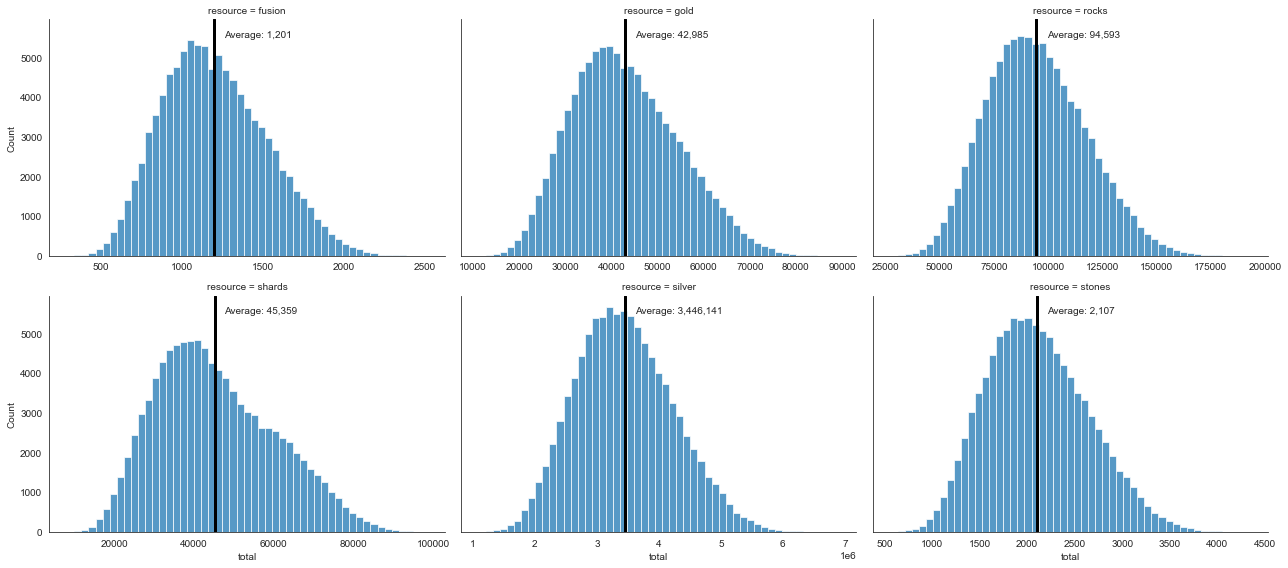

In [131]:
g = sb.FacetGrid(totals, col='resource', sharex=False, col_wrap=3, aspect=1.5, height=4)
g.map(sb.histplot, 'total', bins=51)
g.map(lambda x, **kw: plt.axvline(x.mean(), color="k", lw=3), 'total')
g.map(lambda x, **kwargs: plt.annotate(
    f'Average: {x.mean():,.0f}',
    xy=(x.mean()*1.05, .925),
    xycoords=plt.gca().get_xaxis_transform(),
    ha='left'
), 'total')

### Gear Costs (per piece)

In [132]:
gear_costs_per_sim = simulations.merge(gear_costs, on='level')
for resource in resources:
    gear_costs_per_sim[resource] *= gear_costs_per_sim['attempt']
gear_costs_per_sim

,trial,level,attempt,artisan_rate,rocks,shards,stones,fusion,silver,gold
0,1,7,1,0.0000,404,108,8,6,22380,170
1,2,7,4,0.9207,1616,432,32,24,89520,680
2,3,7,1,0.0000,404,108,8,6,22380,170
3,4,7,1,0.0000,404,108,8,6,22380,170
4,5,7,3,0.5859,1212,324,24,18,67140,510
...,...,...,...,...,...,...,...,...,...,...
1399995,99996,20,2,0.0140,1560,1456,40,28,60640,700
1399996,99997,20,7,0.1045,5460,5096,140,98,212240,2450
1399997,99998,20,4,0.0460,3120,2912,80,56,121280,1400
1399998,99999,20,18,0.3974,14040,13104,360,252,545760,6300


In [133]:
gear_costs_per_sim = (
    gear_costs_per_sim
    .melt(
        id_vars=['level', 'trial'],
        value_vars=resources,
        var_name='resource',
        value_name='total'
    )
)
gear_costs_per_sim

,level,trial,resource,total
0,7,1,rocks,404
1,7,2,rocks,1616
2,7,3,rocks,404
3,7,4,rocks,404
4,7,5,rocks,1212
...,...,...,...,...
8399995,20,99996,gold,700
8399996,20,99997,gold,2450
8399997,20,99998,gold,1400
8399998,20,99999,gold,6300


By level

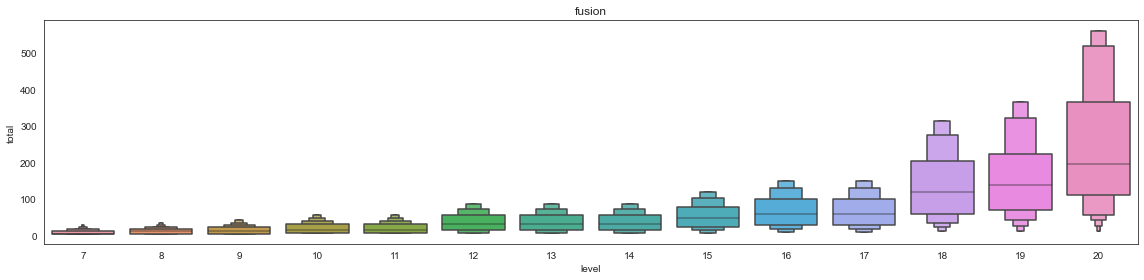

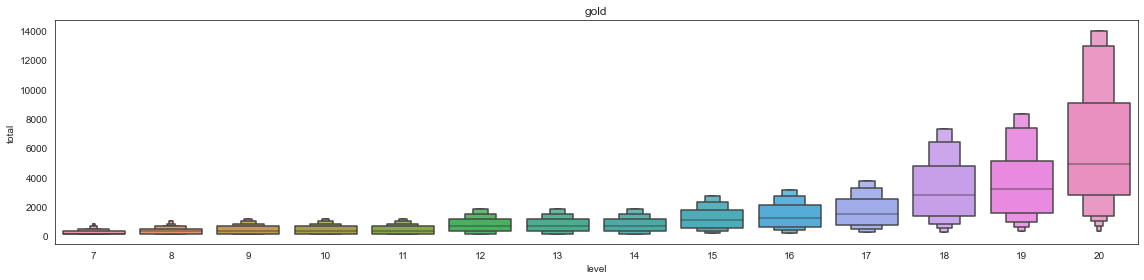

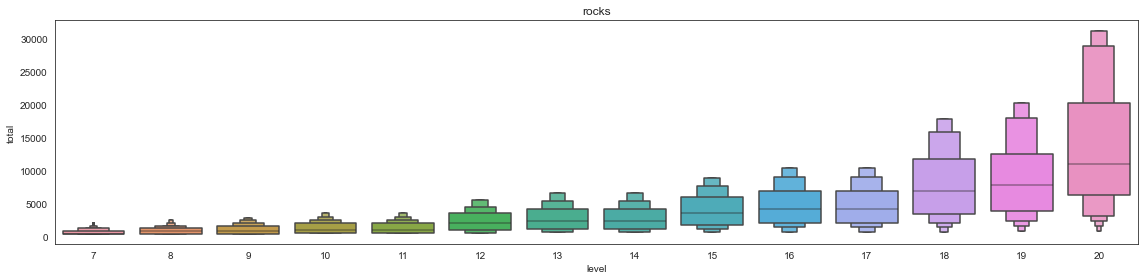

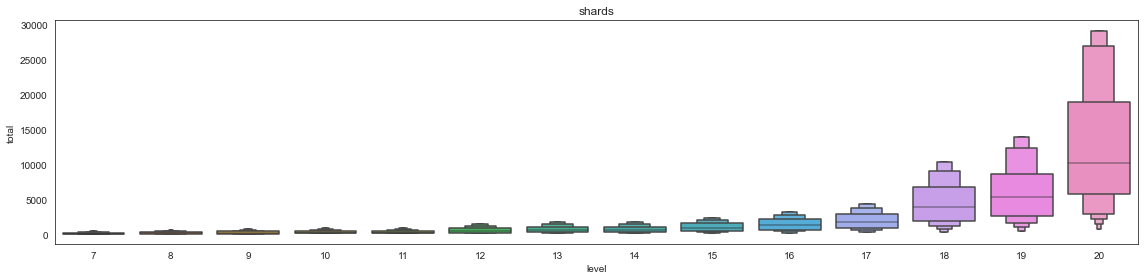

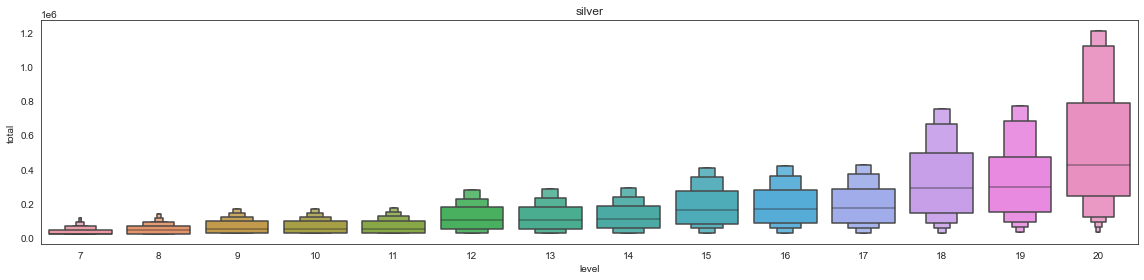

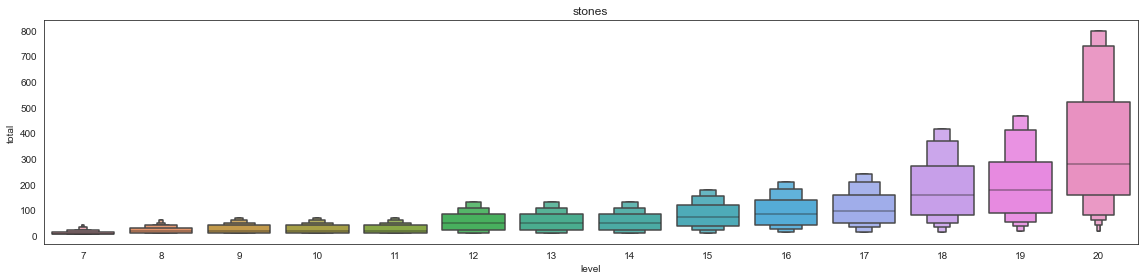

In [134]:
for res, gdf in gear_costs_per_sim.groupby('resource'):
    fig, ax = plt.subplots(figsize=(16, 4))
    sb.boxenplot(data=gdf, x='level', y='total', ax=ax)
    plt.title(res)
    plt.tight_layout()
    plt.show()

Total costs

In [135]:
totals = gear_costs_per_sim.groupby(['trial', 'resource'])['total'].sum().reset_index()
totals

,trial,resource,total
0,1,fusion,798
1,1,gold,18750
2,1,rocks,50274
3,1,shards,24302
4,1,silver,2190420
...,...,...,...
599995,100000,gold,17690
599996,100000,rocks,48348
599997,100000,shards,23208
599998,100000,silver,2066440


Text(0.5, 1.02, 'Gear Honing Totals')

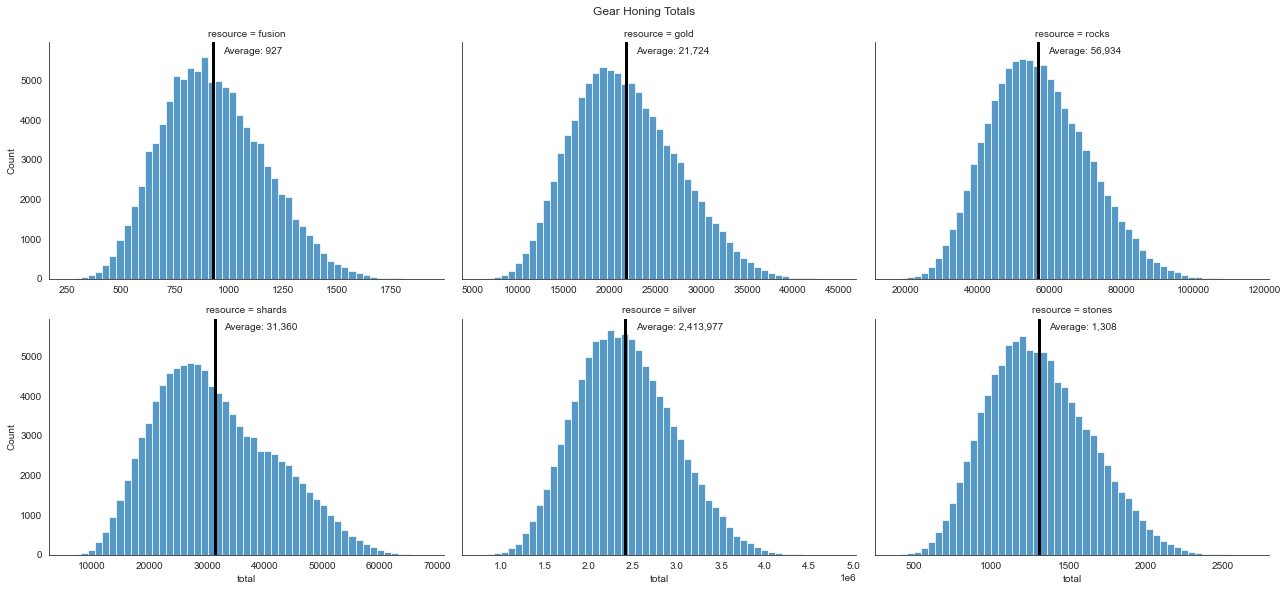

In [136]:
g = sb.FacetGrid(totals, col='resource', sharex=False, col_wrap=3, aspect=1.5, height=4)
g.map(sb.histplot, 'total', bins=51)
g.map(lambda x, **kw: plt.axvline(x.mean(), color="k", lw=3), 'total')
g.map(lambda x, **kwargs: plt.annotate(
    f'Average: {x.mean():,.0f}',
    xy=(x.mean()*1.05, .95),
    xycoords=plt.gca().get_xaxis_transform(),
    ha='left'
), 'total')
plt.suptitle('Gear Honing Totals', y=1.02)

# TODO

- Juicing
- Model attempts (negative binomial by level success_rate/level?)
- Stronghold buffs